In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import seaborn as sns

from numpy.linalg import eig
from datetime import datetime, timedelta
from sklearn.decomposition import PCA

## List

In [20]:
sectors = ['energy', 'materials', 'industrials', 'consumer_discretionary',\
           'consumer_staples', 'health_care', 'financials', 'information_technology',\
           'communication_services', 'utilities', 'real_estate']

models = [
    "gpt-4o-2024-11-20",
    "gpt-4.1",
    "o4-mini",
    "gpt-5",
    "claude-3-7-sonnet-20250219",
    "claude-sonnet-4-20250514",
    "claude-opus-4-20250514",
    "deepseek-chat",
    "deepseek-reasoner",
    "gemini-2.5-pro-preview-05-06",
    "grok-3-latest",
    "grok-3-mini-latest"
]

## HHI

In [21]:
def calculate_hhi(sector_name, portfolio):
    squared_weights = portfolio['Weight'].apply(lambda x: x**2)
    return squared_weights.sum()

In [22]:
with open('metrics/hhi.csv', 'w', encoding='utf-8') as f:
    f.write('model,sector,index\n')

In [23]:
for model in models:
    for sector_name in sectors:
        if model == 'gpt-4o-2024-11-20':
            csv_path = f'cached/gpt/4o_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'gpt-4.1':
            csv_path = f'cached/gpt/4.1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'o4-mini':
            csv_path = f'cached/gpt/o4-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'gpt-5':
            csv_path = f'cached/gpt/5_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        # ds
        elif model == 'deepseek-chat':
            csv_path = f'cached/ds/dsV3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'deepseek-reasoner':
            csv_path = f'cached/ds/dsR1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        # claude
        elif model == 'claude-3-7-sonnet-20250219':
            csv_path = f'cached/claude/sonnet-3.7_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'claude-sonnet-4-20250514':
            csv_path = f'cached/claude/sonnet-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'claude-opus-4-20250514':
            csv_path = f'cached/claude/opus-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        # gemini
        elif model == 'gemini-2.5-pro-preview-05-06':
            csv_path = f'cached/gemini/gemini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        # grok
        elif model == 'grok-3-latest':
            csv_path = f'cached/grok/grok3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'grok-3-mini-latest':
            csv_path = f'cached/grok/grok3-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'

        portfolio = pd.read_csv(csv_path)
        index = calculate_hhi(sector_name, portfolio)

        with open('metrics/hhi.csv', 'a', encoding='utf-8') as f:
            f.write(f'{model},{sector_name},{index}\n')
    

$$
HHI = \sum_{i=1}^n s_i^2
$$

The bigger the index, the less diversified the portfolio is (more weight is assigned to particular companies). In my case, I am using the decimal numbers.

Examples in my case:

- one asset with 100% weught: HHI = 100
- 20 equally weighted assets: HHI = 5

In [24]:
df = pd.read_csv('metrics/hhi.csv')
df['index'] *= 100
# df_sorted = df.sort_values(by='index')
# with pd.option_context('display.max_rows', None):
#     display(df_sorted)
df.sort_values(by='index')

,model,sector,index
130,grok-3-mini-latest,utilities,5.212698
112,grok-3-latest,industrials,5.233051
2,gpt-4o-2024-11-20,industrials,5.288742
79,deepseek-chat,industrials,5.296852
13,gpt-4.1,industrials,5.305036
...,...,...,...
107,gemini-2.5-pro-preview-05-06,communication_services,9.042782
96,deepseek-reasoner,communication_services,9.162364
85,deepseek-chat,communication_services,9.658977
74,claude-opus-4-20250514,communication_services,11.294152


In [25]:
model_mapping = {
    "gpt-4o-2024-11-20": "gpt4o",
    "gpt-4.1": "gpt4.1", 
    "o4-mini": "o4-mini",
    "gpt-5": "gpt5",
    "claude-3-7-sonnet-20250219": "sonnet-3.7",
    "claude-sonnet-4-20250514": "sonnet-4",
    "claude-opus-4-20250514": "opus-4",
    "deepseek-chat": "dsV3",
    "deepseek-reasoner": "dsR1",
    "gemini-2.5-pro-preview-05-06": "gemini",
    "grok-3-latest": "grok3",
    "grok-3-mini-latest": "grok3-mini"
}

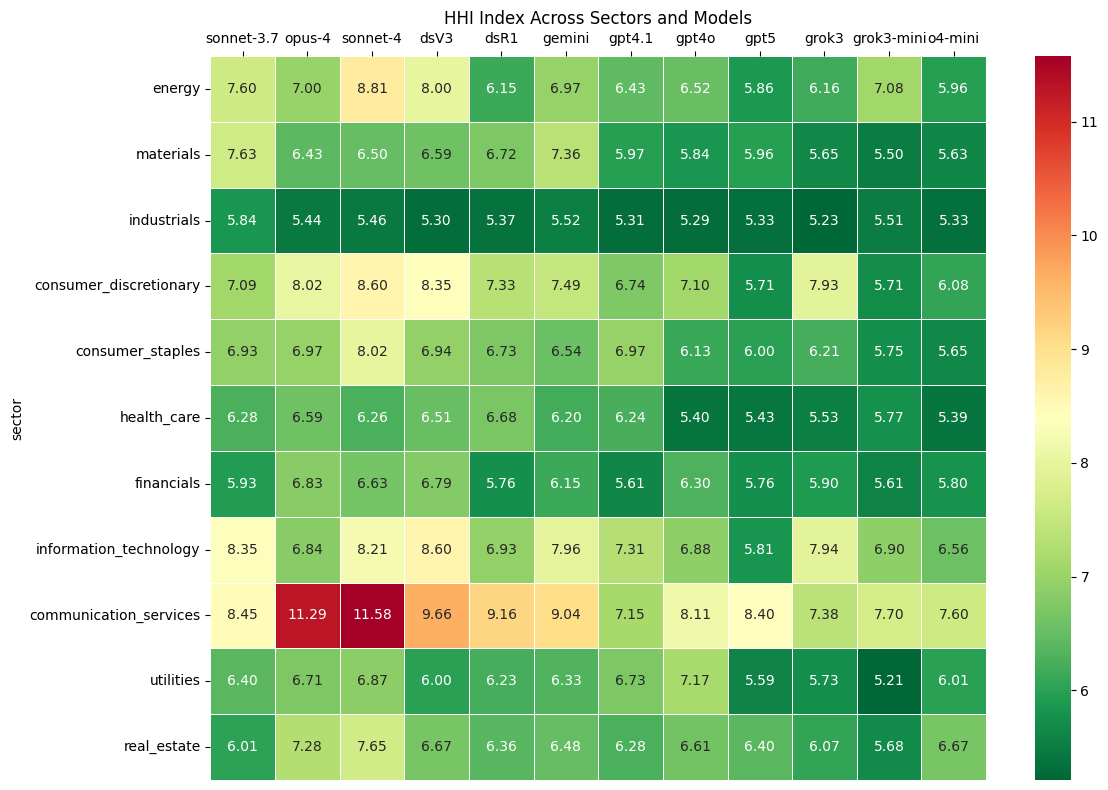

In [26]:
pivot_df = df.pivot(index='sector', columns='model', values='index')
pivot_df.columns = [model_mapping.get(col, col) for col in pivot_df.columns]
sector_order = ['energy', 'materials', 'industrials', 'consumer_discretionary', 'consumer_staples', 'health_care',
                'financials', 'information_technology', 'communication_services', 'utilities', 'real_estate']
pivot_df = pivot_df.reindex(sector_order)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, fmt='.2f', cmap='RdYlGn_r', linewidths=0.5)
plt.title('HHI Index Across Sectors and Models')
plt.tick_params(axis='x', top=True, bottom=False, labeltop=True, labelbottom=False)
plt.tight_layout()
plt.show()

## PCA

In [28]:
def perform_pca(sector_name, alpha=0):
    cevs = []

    for model in models:
        if model == 'gpt-4o-2024-11-20':
            csv_path = f'cached/gpt/4o_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'gpt-4.1':
            csv_path = f'cached/gpt/4.1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'o4-mini':
            csv_path = f'cached/gpt/o4-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'gpt-5':
            csv_path = f'cached/gpt/5_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'deepseek-chat':
            csv_path = f'cached/ds/dsV3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'deepseek-reasoner':
            csv_path = f'cached/ds/dsR1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'claude-3-7-sonnet-20250219':
            csv_path = f'cached/claude/sonnet-3.7_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'claude-sonnet-4-20250514':
            csv_path = f'cached/claude/sonnet-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'claude-opus-4-20250514':
            csv_path = f'cached/claude/opus-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'gemini-2.5-pro-preview-05-06':
            csv_path = f'cached/gemini/gemini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'grok-3-latest':
            csv_path = f'cached/grok/grok3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'grok-3-mini-latest':
            csv_path = f'cached/grok/grok3-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'

        portfolio = pd.read_csv(csv_path)

        csv_path = f'4_returns_outsample/SP500_{sector_name}_returns_since_Jan2025.csv'
        returns_out = pd.read_csv(csv_path)
        required_columns = portfolio['Stock'].tolist()
        returns_out_filtered = returns_out.loc[:, required_columns]
        
        print(f'Processing {sector_name.upper()} sector, {model.upper()} model portfolio')

        pca = PCA()
        pca.fit(returns_out_filtered)

        explained_variance_ratio = pca.explained_variance_ratio_
        print('Explained variance ratio: ', explained_variance_ratio)
        
        cumulative_explained_variance = np.cumsum(explained_variance_ratio)
        cevs.append(cumulative_explained_variance)

    plt.figure(figsize=(8, 6))

    for i, cumulative_explained_variance in enumerate(cevs):
        plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', label=models[i])

    plt.axhline(y=alpha, color='red', linestyle='--')

    plt.xlabel('Number of principal components')
    plt.ylabel('Cumulative explained variance ratio')
    plt.title(f'{sector_name} sector portfolio')
    # plt.xticks(range(1, len(cumulative_explained_variance) + 1, 1))
    plt.legend(models, loc='lower right')
    plt.show()



Processing ENERGY sector, GPT-4O-2024-11-20 model portfolio
Explained variance ratio:  [5.51389811e-01 1.56077618e-01 7.02081884e-02 4.45514365e-02
 3.42043422e-02 2.94146451e-02 2.30323008e-02 1.47926445e-02
 1.36995305e-02 1.21448061e-02 1.08841730e-02 8.19170913e-03
 6.56267611e-03 6.28823688e-03 5.81105721e-03 4.56078108e-03
 3.31531519e-03 2.30718952e-03 2.19146478e-03 3.72074397e-04]
Processing ENERGY sector, GPT-4.1 model portfolio
Explained variance ratio:  [5.24320620e-01 1.77568431e-01 7.06623222e-02 4.72940679e-02
 3.43003618e-02 2.90265926e-02 2.64852922e-02 1.67906726e-02
 1.28074895e-02 1.19000004e-02 9.11638166e-03 7.99067462e-03
 7.09188372e-03 6.14457254e-03 5.53787575e-03 4.80454243e-03
 3.40008933e-03 2.21530108e-03 2.12517309e-03 4.17656068e-04]
Processing ENERGY sector, O4-MINI model portfolio
Explained variance ratio:  [5.24320620e-01 1.77568431e-01 7.06623222e-02 4.72940679e-02
 3.43003618e-02 2.90265926e-02 2.64852922e-02 1.67906726e-02
 1.28074895e-02 1.1900000

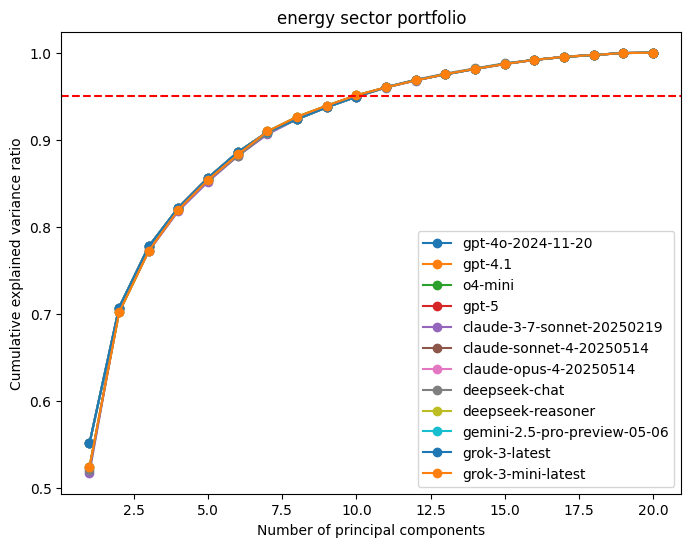

Processing MATERIALS sector, GPT-4O-2024-11-20 model portfolio
Explained variance ratio:  [0.33725942 0.141994   0.10395167 0.09560876 0.05487184 0.04238618
 0.04036388 0.03664276 0.03156192 0.02384601 0.02003508 0.01553627
 0.01361852 0.01106689 0.00832935 0.00666511 0.00569743 0.00483232
 0.00391556 0.00181702]
Processing MATERIALS sector, GPT-4.1 model portfolio
Explained variance ratio:  [0.33135198 0.1534647  0.10544273 0.08301223 0.0542363  0.04201834
 0.0395515  0.02922493 0.02691745 0.02547999 0.02424054 0.0209355
 0.01440776 0.01317963 0.01008635 0.00801976 0.00718779 0.00498553
 0.00409993 0.00215706]
Processing MATERIALS sector, O4-MINI model portfolio
Explained variance ratio:  [0.35474192 0.1506999  0.0893509  0.08543499 0.05320363 0.04091627
 0.03819126 0.03364545 0.02964479 0.02431673 0.0233839  0.01894505
 0.01358051 0.01135581 0.01043232 0.00613077 0.00559577 0.0051251
 0.00333973 0.00196521]
Processing MATERIALS sector, GPT-5 model portfolio
Explained variance ratio: 

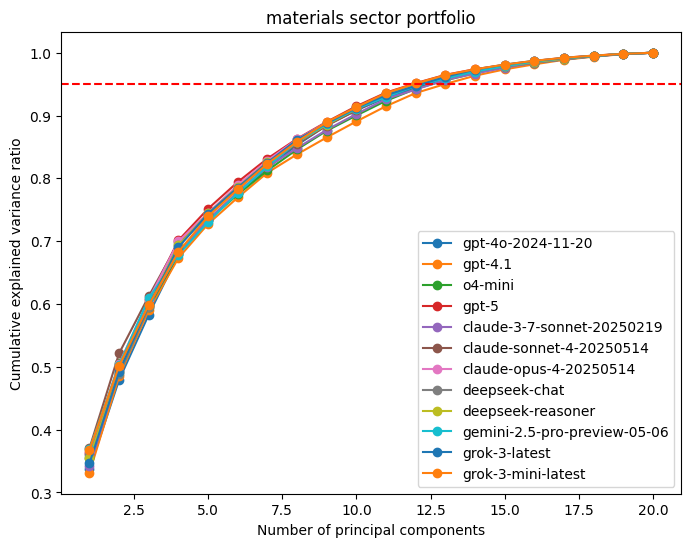

Processing INDUSTRIALS sector, GPT-4O-2024-11-20 model portfolio
Explained variance ratio:  [0.34213649 0.19394901 0.09419748 0.07972936 0.05638026 0.04759834
 0.03515565 0.03147015 0.02612767 0.01915157 0.01583369 0.01352785
 0.01141953 0.00826168 0.00766331 0.00587688 0.00393726 0.0034141
 0.0023228  0.00184693]
Processing INDUSTRIALS sector, GPT-4.1 model portfolio
Explained variance ratio:  [0.39430531 0.17745979 0.08529884 0.06129106 0.04729706 0.03816175
 0.03573607 0.02872149 0.02476655 0.01902492 0.01716619 0.01500339
 0.01254578 0.01072219 0.0083179  0.00757546 0.00647735 0.0049186
 0.0031986  0.00201169]
Processing INDUSTRIALS sector, O4-MINI model portfolio
Explained variance ratio:  [0.35219542 0.19699572 0.09349708 0.07922261 0.05147687 0.04645536
 0.03464074 0.02979256 0.02152279 0.02124541 0.01466433 0.01137358
 0.00981526 0.00835768 0.00744339 0.00707873 0.00534878 0.00381682
 0.00292295 0.00213392]
Processing INDUSTRIALS sector, GPT-5 model portfolio
Explained variance

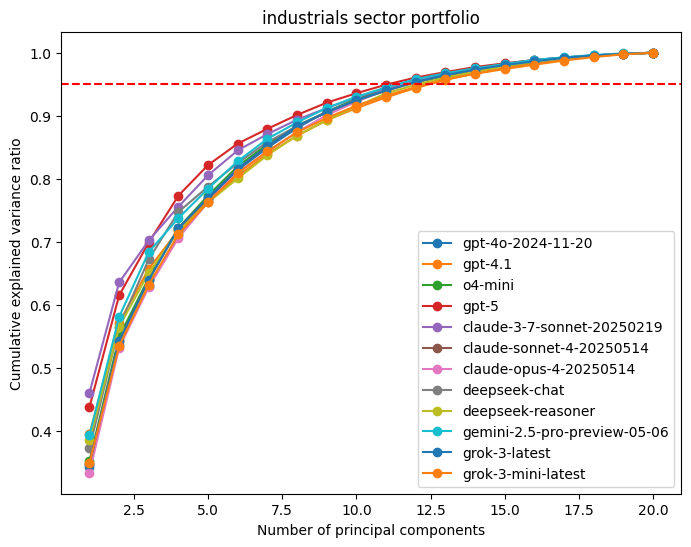

Processing CONSUMER_DISCRETIONARY sector, GPT-4O-2024-11-20 model portfolio
Explained variance ratio:  [0.36959031 0.13975608 0.09252456 0.07412834 0.05453172 0.04988342
 0.04058503 0.03468574 0.03397561 0.02759136 0.01695028 0.01390571
 0.01197699 0.01100273 0.00968982 0.00704991 0.0048777  0.0029563
 0.00243091 0.00190748]
Processing CONSUMER_DISCRETIONARY sector, GPT-4.1 model portfolio
Explained variance ratio:  [0.3651444  0.17563988 0.08995002 0.07751548 0.05360965 0.05064055
 0.04250141 0.02586953 0.02338096 0.01861279 0.01696301 0.01499108
 0.01206998 0.00988086 0.00753759 0.00560073 0.00340753 0.00281521
 0.00221673 0.00165263]
Processing CONSUMER_DISCRETIONARY sector, O4-MINI model portfolio
Explained variance ratio:  [0.35719049 0.16325844 0.08827225 0.06962262 0.05617144 0.05360886
 0.03647186 0.03561097 0.03129271 0.01977349 0.01814217 0.01545515
 0.0137248  0.01136937 0.00923038 0.00825633 0.00473538 0.00317066
 0.00277236 0.00187027]
Processing CONSUMER_DISCRETIONARY sec

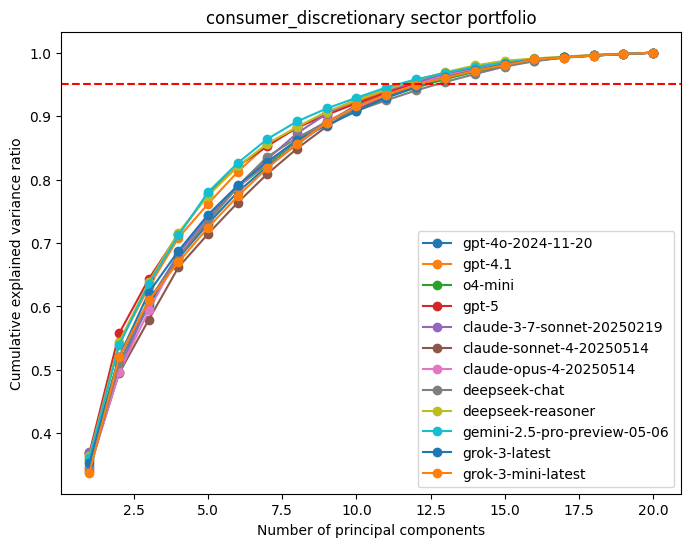

Processing CONSUMER_STAPLES sector, GPT-4O-2024-11-20 model portfolio
Explained variance ratio:  [4.58875095e-01 1.36102053e-01 1.07970391e-01 7.13538215e-02
 5.09411773e-02 4.43670482e-02 2.52739298e-02 1.89041165e-02
 1.49570237e-02 1.41801854e-02 1.21311522e-02 9.43159471e-03
 8.30060213e-03 7.57085936e-03 6.60396124e-03 4.49431238e-03
 3.39252383e-03 3.09737928e-03 1.84175681e-03 2.11015698e-04]
Processing CONSUMER_STAPLES sector, GPT-4.1 model portfolio
Explained variance ratio:  [3.76326576e-01 2.70522814e-01 9.31769159e-02 7.52174744e-02
 4.66059984e-02 2.96062215e-02 2.16369030e-02 1.70528889e-02
 1.44332578e-02 1.21838139e-02 9.11606926e-03 7.78533204e-03
 6.12652448e-03 5.75327685e-03 4.50146152e-03 3.68327218e-03
 2.55356646e-03 2.01608524e-03 1.53338874e-03 1.68160080e-04]
Processing CONSUMER_STAPLES sector, O4-MINI model portfolio
Explained variance ratio:  [0.46694229 0.14151862 0.1026941  0.07330265 0.05202166 0.0293623
 0.02570986 0.02047658 0.01533569 0.01259003 0.0116

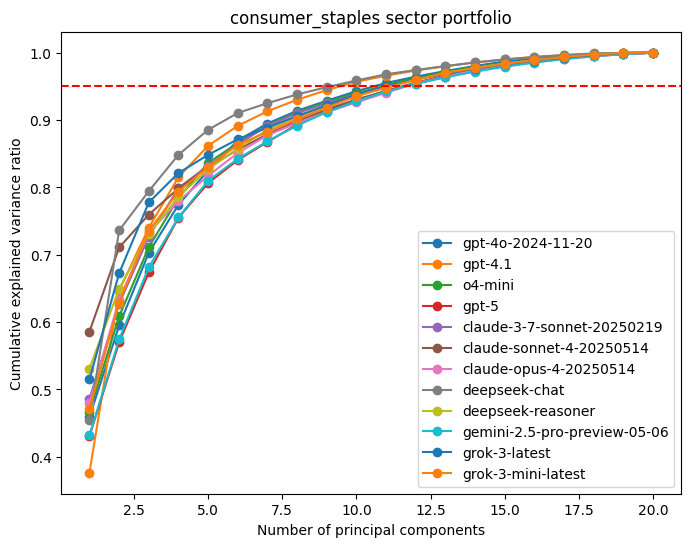

Processing HEALTH_CARE sector, GPT-4O-2024-11-20 model portfolio
Explained variance ratio:  [0.36080882 0.17724691 0.08917062 0.0550832  0.05002674 0.04408763
 0.03426552 0.0317771  0.02888569 0.02353054 0.02072406 0.01917014
 0.0151739  0.0124421  0.01078505 0.00754884 0.00675767 0.00590688
 0.00465933 0.00194925]
Processing HEALTH_CARE sector, GPT-4.1 model portfolio
Explained variance ratio:  [0.21909989 0.16722072 0.10532947 0.07344528 0.06731214 0.05848526
 0.05191176 0.04409497 0.04212588 0.03010448 0.0268031  0.02398747
 0.01855297 0.01732608 0.01442683 0.01234538 0.01008    0.00831302
 0.00473918 0.0042961 ]
Processing HEALTH_CARE sector, O4-MINI model portfolio
Explained variance ratio:  [0.26069898 0.15279007 0.10312798 0.0715171  0.06405917 0.05442624
 0.04924958 0.03958148 0.03642313 0.02942744 0.02899312 0.02356658
 0.0168804  0.01596328 0.0136049  0.01061508 0.00971093 0.00830612
 0.00666067 0.00439775]
Processing HEALTH_CARE sector, GPT-5 model portfolio
Explained varian

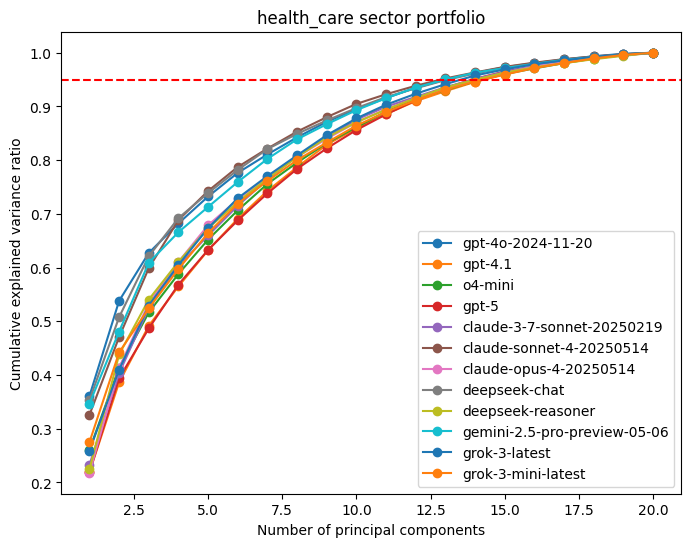

Processing FINANCIALS sector, GPT-4O-2024-11-20 model portfolio
Explained variance ratio:  [0.56661208 0.10633562 0.09234462 0.04317107 0.03485537 0.02719553
 0.02257173 0.01911435 0.01736121 0.01321227 0.01268189 0.00921121
 0.00801402 0.00697128 0.00518307 0.00499661 0.00346323 0.00300594
 0.00222022 0.00147867]
Processing FINANCIALS sector, GPT-4.1 model portfolio
Explained variance ratio:  [0.59639395 0.11178132 0.04849843 0.04040502 0.03180021 0.02738101
 0.02290762 0.02160315 0.01714515 0.01380254 0.01287306 0.01178987
 0.0098216  0.00839645 0.00662376 0.00592136 0.0044887  0.00375057
 0.00267612 0.00194009]
Processing FINANCIALS sector, O4-MINI model portfolio
Explained variance ratio:  [0.59173585 0.11877641 0.05326283 0.0364178  0.03158087 0.02697139
 0.02295184 0.0218572  0.01889331 0.01388195 0.0112081  0.01027277
 0.00925698 0.00738193 0.00692858 0.00492853 0.00460838 0.00435887
 0.00277998 0.00194642]
Processing FINANCIALS sector, GPT-5 model portfolio
Explained variance r

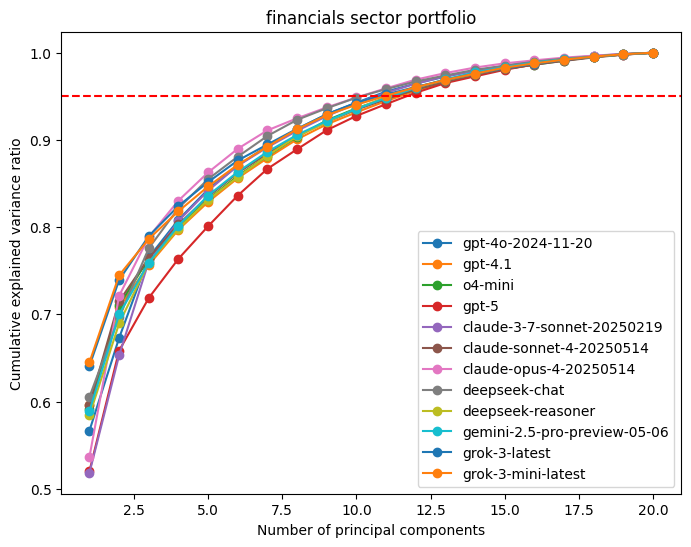

Processing INFORMATION_TECHNOLOGY sector, GPT-4O-2024-11-20 model portfolio
Explained variance ratio:  [0.48867136 0.12052274 0.09885875 0.05463446 0.0367109  0.03114741
 0.0282234  0.02508263 0.02128772 0.01898538 0.01756512 0.01573601
 0.00914207 0.00779204 0.00684406 0.00598055 0.00457734 0.00359715
 0.00280792 0.00183301]
Processing INFORMATION_TECHNOLOGY sector, GPT-4.1 model portfolio
Explained variance ratio:  [0.53391161 0.12772389 0.06809515 0.04038994 0.03607493 0.03279897
 0.02794502 0.02345803 0.02143985 0.01966656 0.01444347 0.01110456
 0.00945796 0.00813042 0.00647261 0.00645037 0.00411097 0.00317306
 0.00276383 0.00238879]
Processing INFORMATION_TECHNOLOGY sector, O4-MINI model portfolio
Explained variance ratio:  [0.44500007 0.12894262 0.10867936 0.06773051 0.04218793 0.03891938
 0.02925942 0.02789931 0.02283358 0.01683067 0.01543338 0.01137987
 0.01069313 0.00773744 0.00713154 0.00591229 0.00485618 0.00422909
 0.00237736 0.00196686]
Processing INFORMATION_TECHNOLOGY se

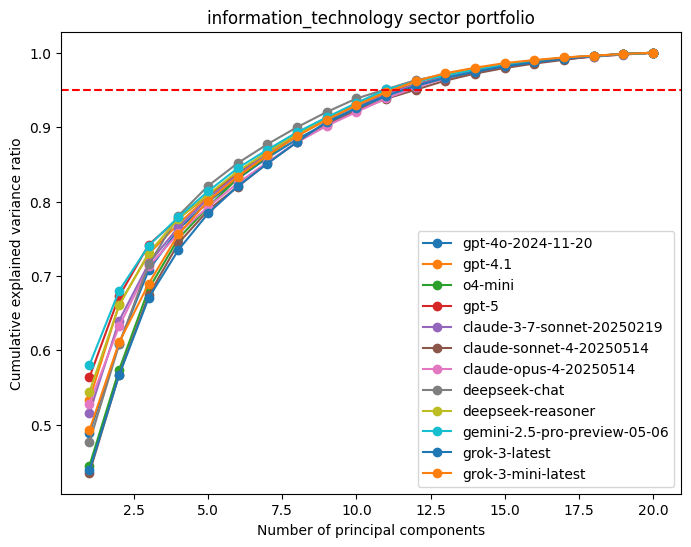

Processing COMMUNICATION_SERVICES sector, GPT-4O-2024-11-20 model portfolio
Explained variance ratio:  [3.06412412e-01 1.46326049e-01 1.07848984e-01 9.14320535e-02
 5.92494903e-02 5.22511718e-02 5.12418289e-02 3.39770327e-02
 3.18855432e-02 2.50283449e-02 2.25538475e-02 1.84713427e-02
 1.50835043e-02 1.14695035e-02 1.05810939e-02 7.39480512e-03
 5.52095563e-03 2.95219095e-03 2.83084017e-04 3.67627941e-05]
Processing COMMUNICATION_SERVICES sector, GPT-4.1 model portfolio
Explained variance ratio:  [2.97452770e-01 1.52017098e-01 1.09232448e-01 9.13709919e-02
 6.45827224e-02 5.23582317e-02 4.90650350e-02 3.32290674e-02
 3.05078941e-02 2.53142385e-02 2.26616776e-02 1.87562713e-02
 1.47363462e-02 1.20708234e-02 8.89556577e-03 7.98342318e-03
 6.20675836e-03 2.98199928e-03 5.39745063e-04 3.68929363e-05]
Processing COMMUNICATION_SERVICES sector, O4-MINI model portfolio
Explained variance ratio:  [3.02419764e-01 1.52023311e-01 1.08091134e-01 9.07045997e-02
 6.43107123e-02 5.19200383e-02 5.03246

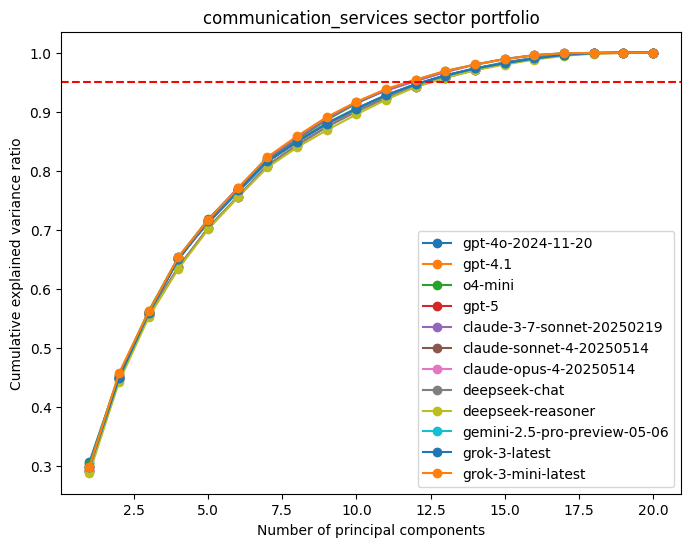

Processing UTILITIES sector, GPT-4O-2024-11-20 model portfolio
Explained variance ratio:  [0.45050817 0.17994396 0.1271357  0.07400004 0.03880765 0.02871368
 0.0181598  0.01471666 0.01149904 0.01111252 0.00839764 0.00727668
 0.00646895 0.00493326 0.00440452 0.00406714 0.00335334 0.00291025
 0.00195161 0.00163939]
Processing UTILITIES sector, GPT-4.1 model portfolio
Explained variance ratio:  [0.52717805 0.20014051 0.06689622 0.04645007 0.03751623 0.02329167
 0.01653324 0.01498233 0.01137462 0.009331   0.00782278 0.0064422
 0.00624136 0.00563066 0.00503908 0.00419564 0.00356541 0.00293806
 0.00245923 0.00197164]
Processing UTILITIES sector, O4-MINI model portfolio
Explained variance ratio:  [0.54216083 0.19709431 0.05722813 0.04554617 0.03652303 0.02383662
 0.01677468 0.01422206 0.01088939 0.00973911 0.00899215 0.00616306
 0.00588186 0.00535646 0.0048002  0.00447051 0.00361477 0.00284873
 0.00226131 0.00159664]
Processing UTILITIES sector, GPT-5 model portfolio
Explained variance ratio:

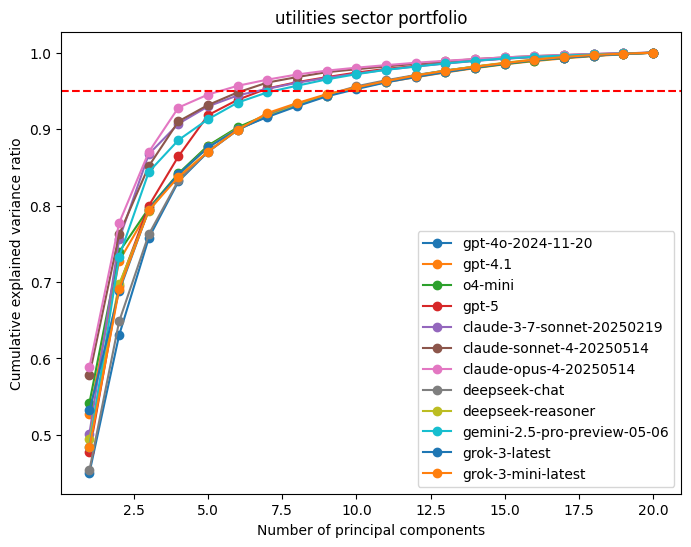

Processing REAL_ESTATE sector, GPT-4O-2024-11-20 model portfolio
Explained variance ratio:  [0.4520062  0.20203711 0.07902974 0.05190906 0.04367708 0.03711215
 0.02354473 0.02202966 0.01574327 0.01427934 0.01191422 0.0103845
 0.00822808 0.00756464 0.00667988 0.00476677 0.00404971 0.00224123
 0.00155902 0.00124361]
Processing REAL_ESTATE sector, GPT-4.1 model portfolio
Explained variance ratio:  [0.48403333 0.18382864 0.07735388 0.04173382 0.03762286 0.03318295
 0.02672311 0.02405333 0.01789635 0.01502279 0.01253095 0.01019955
 0.00891699 0.00723558 0.00489466 0.00467256 0.00381669 0.00334192
 0.0018217  0.00111833]
Processing REAL_ESTATE sector, O4-MINI model portfolio
Explained variance ratio:  [0.44218825 0.18640135 0.09108985 0.05583255 0.04286323 0.03703975
 0.02587272 0.02139585 0.02050726 0.01439889 0.01436666 0.01040344
 0.00849287 0.00761614 0.00698266 0.00411217 0.00379212 0.00326217
 0.00223953 0.00114253]
Processing REAL_ESTATE sector, GPT-5 model portfolio
Explained varianc

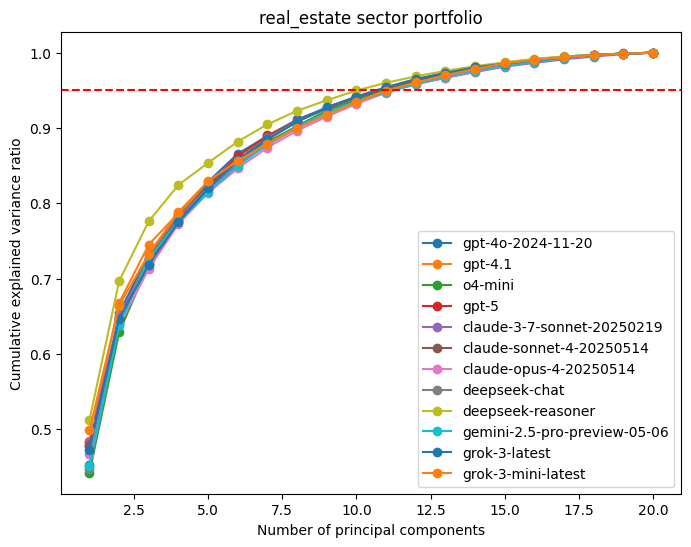

In [29]:
for sector_name in sectors:
    perform_pca(sector_name, 0.95)

## Volatility (out-of-sample portfolio volatility)

In [79]:
df = pd.read_csv('metrics/portfolio_volatilities.csv')
df.sort_values(by='volatility')

,model,sector,time split,volatility
296,grok3-mini,consumer_staples,Apr,0.01278
287,gpt4.1,consumer_staples,Apr,0.01279
499,gpt5,consumer_staples,Apr,0.01282
288,o4-mini,consumer_staples,Apr,0.01310
286,gpt4o,consumer_staples,Apr,0.01330
...,...,...,...,...
324,opus-4,information_technology,Apr,0.10365
322,sonnet-3.7,information_technology,Apr,0.10605
327,gemini,information_technology,Apr,0.10667
326,dsR1,information_technology,Apr,0.11083


In [35]:
## only for display
# df_sorted = df[df['time split']=='Oct'].sort_values(by='volatility')
# with pd.option_context('display.max_rows', None):
#     display(df[df['time split']=='Oct'])

In [80]:
# time_split = 'Oct'
# time_split = 'Jan'
time_split = 'Apr'
# time_split = 'Jan_6months'

In [81]:
df = df[df['time split']==f'{time_split}']

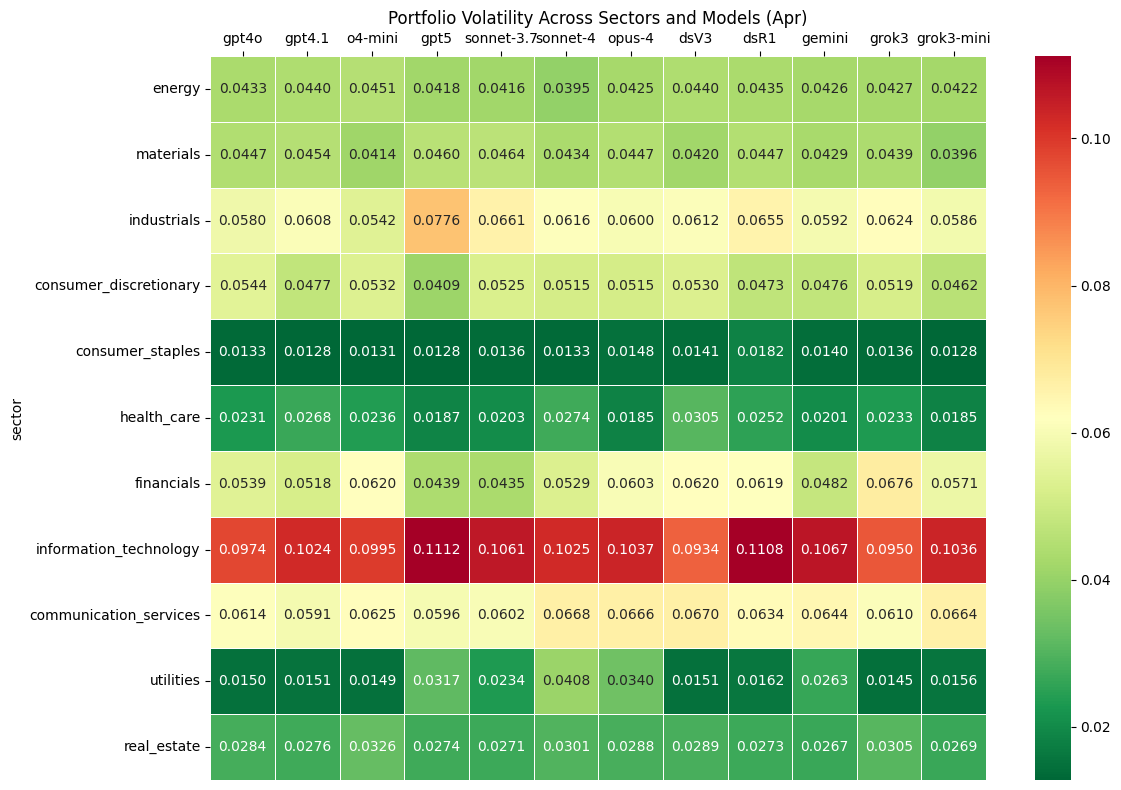

In [82]:
pivot_df = df.pivot(index='sector', columns='model', values='volatility')
pivot_df.columns = [model_mapping.get(col, col) for col in pivot_df.columns]
sector_order = ['energy', 'materials', 'industrials', 'consumer_discretionary', 'consumer_staples', 'health_care',
                'financials', 'information_technology', 'communication_services', 'utilities', 'real_estate']
pivot_df = pivot_df.reindex(sector_order)
model_order = [
    "gpt4o", "gpt4.1", "o4-mini", "gpt5", "sonnet-3.7", "sonnet-4", "opus-4",
    "dsV3", "dsR1", "gemini", "grok3", "grok3-mini"
]
pivot_df = pivot_df[model_order]

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, fmt='.4f', cmap='RdYlGn_r', linewidths=0.5)
plt.title(f'Portfolio Volatility Across Sectors and Models ({time_split})')
plt.tick_params(axis='x', top=True, bottom=False, labeltop=True, labelbottom=False)
plt.tight_layout()
plt.show()

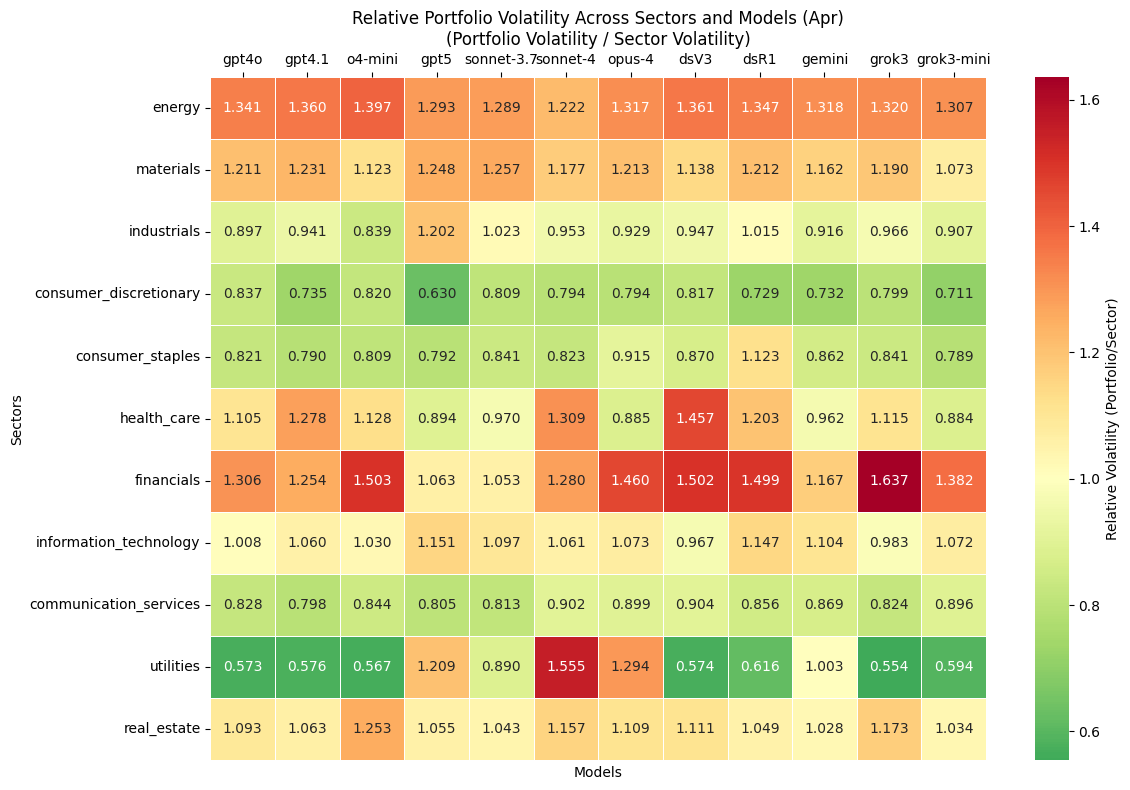

In [83]:
time_split_long = {'Oct': 'Oct2024', 'Jan': 'Jan2025', 'Apr': 'Apr2025', 'Jan_6months': 'Jan2025_6months'}
# Read data of sector benchmark volatility
sector_benchmark = pd.read_csv(f'cached/sector_performance/sector_performance_summary_{time_split_long[time_split]}.csv', index_col=0)

pivot_df = df.pivot(index='sector', columns='model', values='volatility')
pivot_df.columns = [model_mapping.get(col, col) for col in pivot_df.columns]

# define sector order
sector_order = ['energy', 'materials', 'industrials', 'consumer_discretionary', 'consumer_staples', 'health_care',
                'financials', 'information_technology', 'communication_services', 'utilities', 'real_estate']

# Reorder pivot_df
pivot_df = pivot_df.reindex(sector_order)

model_order = [
    "gpt4o", "gpt4.1", "o4-mini", "gpt5", "sonnet-3.7", "sonnet-4", "opus-4",
    "dsV3", "dsR1", "gemini", "grok3", "grok3-mini"
]
pivot_df = pivot_df[model_order]

# calculate relative volatility (portfolio_vol / sector_vol)
relative_volatility_df = pivot_df.copy()

for sector in pivot_df.index:
    if sector in sector_benchmark.index:
        sector_vol = sector_benchmark.loc[sector, 'volatility']
        # portfolio volatility/sector volatility
        relative_volatility_df.loc[sector, :] = pivot_df.loc[sector, :] / sector_vol
    else:
        print(f"Warning: {sector} not found in sector benchmark data")

# Plotting the relative volatility heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(relative_volatility_df, 
            annot=True, 
            fmt='.3f', 
            cmap='RdYlGn_r', 
            linewidths=0.5,
            center=1.0,  # Center point set to 1.0 for better identification of above or below benchmark cases
            cbar_kws={'label': 'Relative Volatility (Portfolio/Sector)'})

plt.title(f'Relative Portfolio Volatility Across Sectors and Models ({time_split})\n(Portfolio Volatility / Sector Volatility)')
plt.tick_params(axis='x', top=True, bottom=False, labeltop=True, labelbottom=False)
plt.xlabel('Models')
plt.ylabel('Sectors')
plt.tight_layout()
plt.show()


In [84]:
print("=== Relative Volatility Table ===")
print(f"Time Split: {time_split}")
print("Calculte: Portfolio Volatility / Sector Volatility")
print("\n")
print(relative_volatility_df.round(3))

print("\n" + "="*80 + "\n")

=== Relative Volatility Table ===
Time Split: Apr
Calculte: Portfolio Volatility / Sector Volatility


                        gpt4o  gpt4.1  o4-mini   gpt5  sonnet-3.7  sonnet-4  \
sector                                                                        
energy                  1.341   1.360    1.397  1.293       1.289     1.222   
materials               1.211   1.231    1.123  1.248       1.257     1.177   
industrials             0.897   0.941    0.839  1.202       1.023     0.953   
consumer_discretionary  0.837   0.735    0.820  0.630       0.809     0.794   
consumer_staples        0.821   0.790    0.809  0.792       0.841     0.823   
health_care             1.105   1.278    1.128  0.894       0.970     1.309   
financials              1.306   1.254    1.503  1.063       1.053     1.280   
information_technology  1.008   1.060    1.030  1.151       1.097     1.061   
communication_services  0.828   0.798    0.844  0.805       0.813     0.902   
utilities               0.57

In [85]:
styled_df = relative_volatility_df.round(3).style.background_gradient(
    cmap='RdYlGn_r', 
    axis=None
).format('{:.3f}')


display(styled_df)  

print("\n" + "="*80 + "\n")

,gpt4o,gpt4.1,o4-mini,gpt5,sonnet-3.7,sonnet-4,opus-4,dsV3,dsR1,gemini,grok3,grok3-mini
sector,,,,,,,,,,,,
energy,1.341,1.360,1.397,1.293,1.289,1.222,1.317,1.361,1.347,1.318,1.320,1.307
materials,1.211,1.231,1.123,1.248,1.257,1.177,1.213,1.138,1.212,1.162,1.190,1.073
industrials,0.897,0.941,0.839,1.202,1.023,0.953,0.929,0.947,1.015,0.916,0.966,0.907
consumer_discretionary,0.837,0.735,0.820,0.630,0.809,0.794,0.794,0.817,0.729,0.732,0.799,0.711
consumer_staples,0.821,0.790,0.809,0.792,0.841,0.823,0.915,0.870,1.123,0.862,0.841,0.789
health_care,1.105,1.278,1.128,0.894,0.970,1.309,0.885,1.457,1.203,0.962,1.115,0.884
financials,1.306,1.254,1.503,1.063,1.053,1.280,1.460,1.502,1.499,1.167,1.637,1.382
information_technology,1.008,1.060,1.030,1.151,1.097,1.061,1.073,0.967,1.147,1.104,0.983,1.072
communication_services,0.828,0.798,0.844,0.805,0.813,0.902,0.899,0.904,0.856,0.869,0.824,0.896


## Effective rank of the matrix functions

In [30]:
def erank_function(eigenvalues):
    '''
    e ** H(eigenvalues)
    H is Shannon entropy
    '''
    shannon_entropy_value, n = 0, len(eigenvalues)

    for i, p_i in enumerate(eigenvalues):
        shannon_entropy_value += (p_i * np.log(p_i))

    return np.e ** (-shannon_entropy_value)

In [31]:
def calculate_erank(returns_out_filtered, model, sector_name, write=False):
    returns_covariance_mtx = np.cov(returns_out_filtered)

    eigenvalues = eig(returns_covariance_mtx)[0] # returns eig, eiv
    eigenvalues_st = [(eig/sum(eigenvalues)) for eig in eigenvalues] # standartize
    erank = erank_function(eigenvalues_st)
    
    if write:
        with open('metrics/erank.csv', 'a', encoding='utf-8') as f:
            f.write(f'{model},{sector_name},{np.real(erank)}\n')

    return np.real(erank)

## Calculate effective rank sectorwise

In [35]:
def process_sectors(sector_name):
    print(f'{sector_name.upper()} SECTOR')
    for model in models:
        if model == 'gpt-4o-2024-11-20':
            csv_path = f'cached/gpt/4o_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'gpt-4.1':
            csv_path = f'cached/gpt/4.1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'o4-mini':
            csv_path = f'cached/gpt/o4-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'gpt-5':
            csv_path = f'cached/gpt/5_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        # ds
        elif model == 'deepseek-chat':
            csv_path = f'cached/ds/dsV3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'deepseek-reasoner':
            csv_path = f'cached/ds/dsR1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        # claude
        elif model == 'claude-3-7-sonnet-20250219':
            csv_path = f'cached/claude/sonnet-3.7_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'claude-sonnet-4-20250514':
            csv_path = f'cached/claude/sonnet-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'claude-opus-4-20250514':
            csv_path = f'cached/claude/opus-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        # gemini
        elif model == 'gemini-2.5-pro-preview-05-06':
            csv_path = f'cached/gemini/gemini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        # grok
        elif model == 'grok-3-latest':
            csv_path = f'cached/grok/grok3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'grok-3-mini-latest':
            csv_path = f'cached/grok/grok3-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'

        portfolio = pd.read_csv(csv_path)

        csv_path = f'4_returns_outsample/SP500_{sector_name}_returns_since_Apr2025.csv'
        returns_out = pd.read_csv(csv_path)
        required_columns = portfolio['Stock'].tolist()
        returns_out_filtered = returns_out.loc[:, required_columns]


        # EFFECTIVE RANK (NO WEIGHTS, RETURNS COVARIANCES)
        erank = calculate_erank(returns_out_filtered, model, sector_name)
        print('my erank: ', erank)

        with open('metrics/erank.csv', 'a', encoding='utf-8') as f:
            f.write(f'{model},{sector_name},{erank}\n')

        # print(f'Processing {sector_name.upper()} sector, {model.upper()} model portfolio')


When we take one stock, say, CLX 15 times (non diversified portfolio) = rank nan.

When we compose a portfolio out of 14 same stocks and 1 different, for example: CLX 14 times + MO 1 time = rank 0.99.

And so on.

In [36]:
if not os.path.exists('metrics/erank.csv'):
    pd.DataFrame(columns=['model', 'sector', 'effective_rank']).to_csv('metrics/erank.csv', index=False)

In [37]:
for sector_name in sectors:
    process_sectors(sector_name)

ENERGY SECTOR
my erank:  7.1695939930387045
my erank:  6.717650170885665
my erank:  6.717650170885674
my erank:  7.1695939930387285
my erank:  6.806201490306951
my erank:  7.169593993038713
my erank:  7.169593993038719
my erank:  6.989795287864937
my erank:  7.169593993038709
my erank:  7.169593993038723
my erank:  7.169593993038727
my erank:  6.71765017088568
MATERIALS SECTOR
my erank:  8.321286884382898
my erank:  8.504518464940308
my erank:  8.07278445228182
my erank:  7.703720152181772
my erank:  8.448886996773583
my erank:  8.034141564166289
my erank:  7.756399686775916
my erank:  8.004632500110212
my erank:  7.912809940203217
my erank:  7.938252166558355
my erank:  7.785778770468422
my erank:  7.54826386936284
INDUSTRIALS SECTOR
my erank:  8.208371187846412
my erank:  8.122155388767546
my erank:  7.689316145773314
my erank:  8.557835303543778
my erank:  10.155098901896574
my erank:  7.7544007806747475
my erank:  9.729910601218199
my erank:  9.017440081228218
my erank:  9.40220892

In [38]:
ranks = pd.read_csv('metrics/erank.csv')
ranks.sort_values(by='effective_rank', ascending=False)

,model,sector,effective_rank
94,grok-3-latest,information_technology,12.335447
53,claude-sonnet-4-20250514,consumer_staples,12.077468
89,claude-sonnet-4-20250514,information_technology,11.914802
91,deepseek-chat,information_technology,11.594162
55,deepseek-chat,consumer_staples,11.520334
...,...,...,...
74,o4-mini,financials,4.641830
112,claude-3-7-sonnet-20250219,utilities,4.509326
111,gpt-5,utilities,3.674960
114,claude-opus-4-20250514,utilities,3.252608


In [40]:
ranks_sorted = ranks.sort_values(by='effective_rank', ascending=False)
with pd.option_context('display.max_rows', None):
    display(ranks_sorted)
ranks_sorted

,model,sector,effective_rank
94,grok-3-latest,information_technology,12.335447
53,claude-sonnet-4-20250514,consumer_staples,12.077468
89,claude-sonnet-4-20250514,information_technology,11.914802
91,deepseek-chat,information_technology,11.594162
55,deepseek-chat,consumer_staples,11.520334
87,gpt-5,information_technology,11.505707
84,gpt-4o-2024-11-20,information_technology,11.463278
86,o4-mini,information_technology,11.425304
92,deepseek-reasoner,information_technology,11.164694
93,gemini-2.5-pro-preview-05-06,information_technology,11.000185


,model,sector,effective_rank
94,grok-3-latest,information_technology,12.335447
53,claude-sonnet-4-20250514,consumer_staples,12.077468
89,claude-sonnet-4-20250514,information_technology,11.914802
91,deepseek-chat,information_technology,11.594162
55,deepseek-chat,consumer_staples,11.520334
...,...,...,...
74,o4-mini,financials,4.641830
112,claude-3-7-sonnet-20250219,utilities,4.509326
111,gpt-5,utilities,3.674960
114,claude-opus-4-20250514,utilities,3.252608


## Sharpe ratio: sector indecies

Comment/Uncomment to select different time split:

In [140]:
# time_split = 'Oct2024'
# time_split = 'Jan2025'
time_split = 'Apr2025'
# time_split = 'Jan2025_6months'

In [141]:
if time_split == 'Oct2024': 
    ## In-sample end date (using 5 years of weekly data prior to end date)
    insample_enddate = datetime(2024, 9, 30)

    ## Out-of-sample period (1 Oct 2024 to 31 Dec 2024) (using daily data))
    outsample_startdate = datetime(2024, 10, 1)
    outsample_enddate   = datetime(2024, 12, 31)

    insample_startdate = insample_enddate - timedelta(weeks=5*52) # five years prior to October 2024
elif time_split == 'Jan2025':
    ## In-sample end date (using 5 years of weekly data prior to end date)
    insample_enddate = datetime(2024, 12, 31)

    ## Out-of-sample period (1 Jan 2025 to 31 Mar 2025) (using daily data))
    outsample_startdate = datetime(2025, 1, 1)
    outsample_enddate   = datetime(2025, 3, 31)

    insample_startdate = insample_enddate - timedelta(weeks=5*52)
elif time_split == 'Apr2025':
    ## In-sample end date (using 5 years of weekly data prior to end date)
    insample_enddate = datetime(2025, 3, 31)

    ## Out-of-sample period (1 Apr 2025 to 30 Jun 2025) (using daily data))
    outsample_startdate = datetime(2025, 4, 1)
    outsample_enddate   = datetime(2025, 6, 30)

    insample_startdate = insample_enddate - timedelta(weeks=5*52)
elif time_split == 'Jan2025_6months':
    ## In-sample end date (using 5 years of weekly data prior to end date)
    insample_enddate = datetime(2024, 12, 31)

    ## Out-of-sample period (1 Jan 2025 to 30 Jun 2025) (using daily data))
    outsample_startdate = datetime(2025, 1, 1)
    outsample_enddate   = datetime(2025, 6, 30)

    insample_startdate = insample_enddate - timedelta(weeks=5*52)

In [142]:
index_tickers = ["^GSPE", '^SP500-15', '^SP500-20', '^SP500-25', '^SP500-30', '^SP500-35', '^SP500-40',\
                 '^SP500-45', '^SP500-50', '^SP500-55', '^SP500-60']

index_data_outs = pd.DataFrame()

for ticker in index_tickers:
    yf_outsample_enddate = outsample_enddate + timedelta(days=1)  # Adjust to include the end date
    index_df = yf.download(ticker, start=outsample_startdate, end=yf_outsample_enddate, interval='1d', auto_adjust=False)
    index_df['Index_Return'] = index_df['Adj Close'].pct_change()
    index_df.dropna(subset=[('Index_Return','')], inplace=True)
    index_data_outs[ticker] = index_df['Index_Return']

index_data_outs.index = pd.to_datetime(index_data_outs.index)

valid_index_tickers_outs = []

for ticker in index_tickers:
    if ticker in index_data_outs.columns and index_data_outs[ticker].notna().all():
        valid_index_tickers_outs.append(ticker)


index_tickers = valid_index_tickers_outs

print("Valid Index Tickers in Out-of-Sample Period")
print(valid_index_tickers_outs)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Valid Index Tickers in Out-of-Sample Period
['^GSPE', '^SP500-15', '^SP500-20', '^SP500-25', '^SP500-30', '^SP500-35', '^SP500-40', '^SP500-45', '^SP500-50', '^SP500-55', '^SP500-60']


In [143]:
index_data_outs

,^GSPE,^SP500-15,^SP500-20,^SP500-25,^SP500-30,^SP500-35,^SP500-40,^SP500-45,^SP500-50,^SP500-55,^SP500-60
Date,,,,,,,,,,,
2025-04-02,0.000667,0.007853,0.009325,0.020235,-0.001821,0.006284,0.008972,0.005609,-0.001362,0.004428,0.004712
2025-04-03,-0.075112,-0.041899,-0.054056,-0.064484,0.006894,-0.007944,-0.050135,-0.068625,-0.047712,-0.006092,-0.029769
2025-04-04,-0.086990,-0.062873,-0.062868,-0.045012,-0.045468,-0.055005,-0.073923,-0.063260,-0.048865,-0.055813,-0.046238
2025-04-07,-0.009403,-0.016544,-0.004435,-0.005357,-0.011772,-0.005964,-0.001456,0.003188,0.010303,-0.015279,-0.023994
2025-04-08,-0.024809,-0.029635,-0.008940,-0.025366,-0.013538,-0.010584,-0.004088,-0.021679,-0.012501,-0.004851,-0.024584
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-24,-0.015136,0.007513,0.008564,0.007132,-0.000344,0.011940,0.014954,0.016114,0.013896,0.003949,0.004119
2025-06-25,-0.004343,-0.007927,-0.009272,-0.011255,-0.013896,0.000891,-0.003844,0.011807,0.005074,-0.013682,-0.024578
2025-06-26,0.015033,0.010884,0.011044,0.011802,-0.001799,0.002369,0.007553,0.006783,0.017725,0.008196,-0.006367


In [144]:
risk_free_rate = 0.02
risk_free_rate_daily = (1 + risk_free_rate) ** (1/252) - 1

sharpe_ratios = {}
for column in index_data_outs.columns:
    returns = index_data_outs[column]
    average_return = np.mean(returns)
    std_dev = np.std(returns)
    sharpe_ratio = (average_return - risk_free_rate_daily) / std_dev
    sharpe_ratios[column] = sharpe_ratio

sharpe_df = pd.DataFrame.from_dict(sharpe_ratios, orient='index', columns=['Sharpe Ratio'])
sharpe_df.index.name = 'Index'

print(sharpe_df)

           Sharpe Ratio
Index                  
^GSPE         -0.064933
^SP500-15      0.024880
^SP500-20      0.103740
^SP500-25      0.074267
^SP500-30      0.001913
^SP500-35     -0.064494
^SP500-40      0.051017
^SP500-45      0.134460
^SP500-50      0.132602
^SP500-55      0.039833
^SP500-60     -0.010021


In [145]:
sharpe_df

,Sharpe Ratio
Index,
^GSPE,-0.064933
^SP500-15,0.024880
^SP500-20,0.103740
^SP500-25,0.074267
^SP500-30,0.001913
^SP500-35,-0.064494
^SP500-40,0.051017
^SP500-45,0.134460
^SP500-50,0.132602


In [146]:
sharpe_df.sort_values(by='Sharpe Ratio', ascending=False)

,Sharpe Ratio
Index,
^SP500-45,0.134460
^SP500-50,0.132602
^SP500-20,0.103740
^SP500-25,0.074267
^SP500-40,0.051017
^SP500-55,0.039833
^SP500-15,0.024880
^SP500-30,0.001913
^SP500-60,-0.010021


In [147]:
if not os.path.exists(f'metrics/sharpe_ratio_{time_split}.csv'):
    pd.DataFrame(columns=['sector', 'model', 'sharpe_ratio']).to_csv(f'metrics/sharpe_ratio_{time_split}.csv', index=False)

for sector_name in sectors:
    for model in models:
        if model == 'gpt-4o-2024-11-20':
            csv_filename = f'cached/gpt/4o_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'gpt-4.1':
            csv_filename = f'cached/gpt/4.1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'o4-mini':
            csv_filename = f'cached/gpt/o4-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == "gpt-5":
            csv_filename = f'cached/gpt/5_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        # ds
        elif model == 'deepseek-chat':
            csv_filename = f'cached/ds/dsV3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'deepseek-reasoner':
            csv_filename = f'cached/ds/dsR1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        # claude
        elif model == 'claude-3-7-sonnet-20250219':
            csv_filename = f'cached/claude/sonnet-3.7_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'claude-sonnet-4-20250514':
            csv_filename = f'cached/claude/sonnet-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'claude-opus-4-20250514':
            csv_filename = f'cached/claude/opus-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        # gemini
        elif model == 'gemini-2.5-pro-preview-05-06':
            csv_filename = f'cached/gemini/gemini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        # grok
        elif model == 'grok-3-latest':
            csv_filename = f'cached/grok/grok3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'grok-3-mini-latest':
            csv_filename = f'cached/grok/grok3-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'


        portfolio = pd.read_csv(csv_filename)
        stocks_in_portfolio = portfolio['Stock']
        weights = portfolio.sort_values(by='Stock')['Weight']

        csv_filename_returns = f'4_returns_outsample/SP500_{sector_name}_returns_since_{time_split}.csv'
        returns_df = pd.read_csv(csv_filename_returns)
        returns_df = returns_df[stocks_in_portfolio]

        risk_free_rate = 0.02
        risk_free_rate_daily = (1 + risk_free_rate) ** (1/252) - 1  # Convert annual risk-free rate to daily rate

        weighted_returns = returns_df.T * weights
        portfolio_return = weighted_returns.sum(axis=1)

        avg_portfolio_return = np.mean(portfolio_return)
        std_portfolio_return = np.std(portfolio_return)

        # std_portfolio_return = np.sqrt(np.dot(weights, np.dot(np.cov(returns_df), weights)))

        sharpe_ratio = (avg_portfolio_return - risk_free_rate_daily) / std_portfolio_return
        print(sharpe_ratio)

        with open(f'metrics/sharpe_ratio_{time_split}.csv', 'a', encoding='utf-8') as f:
            f.write(f'{sector_name},{model},{sharpe_ratio}\n')

-3.65857375052998
-3.11353822671714
-3.4126195047704853
-3.329259784605934
-3.1790796809023614
-3.6305140361450263
-3.6901608764975538
-3.6255857954749398
-3.3114891081605684
-3.618110995269579
-3.6296986878371627
-3.0864443064759994
-0.5912779319504784
-0.777386364220875
0.161725223981247
-0.926366316838175
-1.4865513731421602
-0.9157795467307196
-0.8689862267938989
-0.9101214897392226
-1.0072064019755302
-0.9277591936257646
-0.845420919398566
-1.0331189539748549
-1.760531737549207
0.12975644432749914
-1.4689893327825108
0.08547512441121735
-1.2305189491448763
-0.4569450795248766
-1.297519843533869
-0.420226205443793
-0.8231874141862402
-0.9254133248954383
-0.892775252300936
0.6884983848158706
-0.7796882197207834
-0.6339928446547105
0.2863232464838067
-0.6966143011426915
0.0813795758310695
-1.614480362037227
-0.8121609217179335
-1.0988079563839412
-0.7175824847856507
-0.6620797107109195
-0.8695690832237536
-0.8577489692712386
-0.5912323581870296
-0.9733404266701635
-0.2329083242372714

In [148]:
sh = pd.read_csv(f'metrics/sharpe_ratio_{time_split}.csv')
sh.sort_values(by='sector')

,sector,model,sharpe_ratio
96,communication_services,gpt-4o-2024-11-20,-1.586843
99,communication_services,gpt-5,-1.375694
100,communication_services,claude-3-7-sonnet-20250219,-1.629847
101,communication_services,claude-sonnet-4-20250514,-1.526907
102,communication_services,claude-opus-4-20250514,-1.711452
...,...,...,...
110,utilities,o4-mini,-0.304243
109,utilities,gpt-4.1,-1.156281
108,utilities,gpt-4o-2024-11-20,-0.786710
118,utilities,grok-3-latest,-0.645041


## Sharpe ratios for every sector portfolio

In [149]:
def calculate_sharpe_ratio(returns_df, weights):
    risk_free_rate = 0.02
    risk_free_rate_daily = (1 + risk_free_rate) ** (1/252) - 1  # Convert annual risk-free rate to daily rate

    weighted_returns = returns_df.T * weights
    portfolio_return = weighted_returns.sum(axis=1)
    avg_portfolio_return = np.mean(portfolio_return)
    std_portfolio_return = np.std(portfolio_return)

    sharpe_ratio = (avg_portfolio_return - risk_free_rate_daily) / std_portfolio_return
        
    return sharpe_ratio

In [150]:
model_names = ["gpt4o", "gpt4.1", "o4-mini", "gpt5", "sonnet-3.7", "sonnet-4", "opus-4", "dsV3", "dsR1", "gemini", "grok3", "grok3-mini"]

In [151]:
columns = ['sector']
for model in model_names:
    columns.extend([
        f'{model}_model_weighted',
        f'{model}_equally_weighted', 
        f'{model}_minvar',
        f'{model}_maxret',
        f'{model}_maxsharpe'
    ])
if not os.path.exists(f'metrics/sharpe_ratios_all_{time_split}.csv'):
    pd.DataFrame(columns=columns).to_csv(f'metrics/sharpe_ratios_all_{time_split}.csv', index=False)

In [152]:
for sector_name in sectors:
    with open(f'metrics/sharpe_ratios_all_{time_split}.csv', 'a', encoding='utf-8') as f:
        f.write(f'{sector_name},')

    for model in model_names:
        if model == 'gpt4o':
            csv_filename = f'cached/gpt/4o_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'gpt4.1':
            csv_filename = f'cached/gpt/4.1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'o4-mini':
            csv_filename = f'cached/gpt/o4-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'gpt-5':
            csv_filename = f'cached/gpt/5_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        # claude
        elif model == 'sonnet-3.7':
            csv_filename = f'cached/claude/sonnet-3.7_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'sonnet-4':
            csv_filename = f'cached/claude/sonnet-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'opus-4':
            csv_filename = f'cached/claude/opus-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        # ds
        elif model == 'dsV3':
            csv_filename = f'cached/ds/dsV3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'dsR1':
            csv_filename = f'cached/ds/dsR1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        # gemini
        elif model == 'gemini':
            csv_filename = f'cached/gemini/gemini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        # grok
        elif model == 'grok3':
            csv_filename = f'cached/grok/grok3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'grok3-mini':
            csv_filename = f'cached/grok/grok3-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'


        portfolio = pd.read_csv(csv_filename)
        stocks_in_portfolio = portfolio['Stock']
        weights = portfolio.sort_values(by='Stock')['Weight']
        n = len(stocks_in_portfolio)
        weights_equal = np.array([1/n for _ in range(n)]).reshape(n,1)

        csv_filename_returns = f'4_returns_outsample/SP500_{sector_name}_returns_since_{time_split}.csv'
        returns_df = pd.read_csv(csv_filename_returns)
        returns_df_portfolio = returns_df[stocks_in_portfolio].sort_index(axis=1)

        path_minvar = f'cached/efficient_portfolios/{model}_{sector_name}_{time_split}_minvar_bounded.csv'
        df_minvar = pd.read_csv(path_minvar, header=None).transpose()
        df_minvar.columns = ['Stock', 'Weight']
        df_minvar = df_minvar.sort_values(by='Stock')
        weights_minvar = np.array(df_minvar['Weight'].apply(lambda x: float(x)).tolist()).reshape(len(df_minvar),1)
        returns_df_minvar = returns_df[df_minvar['Stock']].sort_index(axis=1)

        path_maxret = f'cached/efficient_portfolios/{model}_{sector_name}_{time_split}_maxret_bounded.csv'
        df_maxret = pd.read_csv(path_maxret, header=None).transpose()
        df_maxret.columns = ['Stock', 'Weight']
        df_maxret = df_maxret.sort_values(by='Stock')
        weights_maxret = np.array(df_maxret['Weight'].apply(lambda x: float(x)).tolist()).reshape(len(df_maxret),1)
        returns_df_maxret = returns_df[df_maxret['Stock']].sort_index(axis=1)

        path_maxsharpe = f'cached/efficient_portfolios/{model}_{sector_name}_{time_split}_maxsharpe_bounded.csv'
        df_maxsharpe = pd.read_csv(path_maxsharpe, header=None).transpose()
        df_maxsharpe.columns = ['Stock', 'Weight']
        df_maxsharpe = df_maxsharpe.sort_values(by='Stock')
        weights_maxsharpe = np.array(df_maxsharpe['Weight'].apply(lambda x: float(x)).tolist()).reshape(len(df_maxsharpe),1)
        returns_df_maxsharpe = returns_df[df_maxsharpe['Stock']].sort_index(axis=1)

        sharpe_ratio_weighted = calculate_sharpe_ratio(returns_df_portfolio, weights)
        sharpe_ratio_equal = calculate_sharpe_ratio(returns_df_portfolio, weights_equal)
        sharpe_ratio_minvar = calculate_sharpe_ratio(returns_df_minvar, weights_minvar)
        sharpe_ratio_maxret = calculate_sharpe_ratio(returns_df_maxret, weights_maxret)
        sharpe_ratio_maxsharpe = calculate_sharpe_ratio(returns_df_maxsharpe, weights_maxsharpe)

        print(sector_name, model, sharpe_ratio_weighted, 'llm weighted')
        print(sector_name, model, sharpe_ratio_equal, 'equally weighted')
        print(sector_name, model, sharpe_ratio_minvar, 'minvar')
        print(sector_name, model, sharpe_ratio_maxret, 'maxret')
        print(sector_name, model, sharpe_ratio_maxsharpe, 'max sharpe')

        with open(f'metrics/sharpe_ratios_all_{time_split}.csv', 'a', encoding='utf-8') as f:
            f.write(f'{sharpe_ratio_weighted},{sharpe_ratio_equal},{sharpe_ratio_minvar},{sharpe_ratio_maxret},{sharpe_ratio_maxsharpe},')
    with open(f'metrics/sharpe_ratios_all_{time_split}.csv', 'a', encoding='utf-8') as f:
        f.write('\n')


energy gpt4o -3.658573750529981 llm weighted
energy gpt4o -0.8376028274581206 equally weighted
energy gpt4o -0.5402435120775079 minvar
energy gpt4o -0.4315746956048675 maxret
energy gpt4o -0.33182289191074454 max sharpe
energy gpt4.1 -3.11353822671714 llm weighted
energy gpt4.1 -0.6580881828518943 equally weighted
energy gpt4.1 -0.45116255649404896 minvar
energy gpt4.1 -0.22442999098499025 maxret
energy gpt4.1 -0.1423691770958421 max sharpe
energy o4-mini -3.4126195047704853 llm weighted
energy o4-mini -0.6580881828518943 equally weighted
energy o4-mini -0.45116255649404885 minvar
energy o4-mini -0.22442999098499025 maxret
energy o4-mini -0.14236917709584213 max sharpe
energy gpt5 -3.4126195047704853 llm weighted
energy gpt5 -0.6580881828518943 equally weighted
energy gpt5 -0.540243512077508 minvar
energy gpt5 -0.4315746956048672 maxret
energy gpt5 -0.33182289191074443 max sharpe
energy sonnet-3.7 -3.179079680902362 llm weighted
energy sonnet-3.7 -0.6610605246836532 equally weighted
en

In [153]:
with open(f'metrics/sharpe_ratios_all_{time_split}.csv', 'r', encoding='utf-8') as f:
    lines = [line.rstrip(',\n') + '\n' for line in f]

with open(f'metrics/sharpe_ratios_all_{time_split}.csv', 'w', encoding='utf-8') as f:
    f.writelines(lines)


## metric of out-of-sample Sharpe ratio

In [154]:
df = pd.read_csv(f'metrics/sharpe_ratios_all_{time_split}.csv')

In [155]:
df

,sector,gpt4o_model_weighted,gpt4o_equally_weighted,gpt4o_minvar,gpt4o_maxret,gpt4o_maxsharpe,gpt4.1_model_weighted,gpt4.1_equally_weighted,gpt4.1_minvar,gpt4.1_maxret,...,grok3_model_weighted,grok3_equally_weighted,grok3_minvar,grok3_maxret,grok3_maxsharpe,grok3-mini_model_weighted,grok3-mini_equally_weighted,grok3-mini_minvar,grok3-mini_maxret,grok3-mini_maxsharpe
0,energy,-3.658574,-0.837603,-0.540244,-0.431575,-0.331823,-3.113538,-0.658088,-0.451163,-0.224430,...,-3.629699,-0.837603,-0.540244,-0.431575,-0.331823,-3.086444,-0.658088,-0.451163,-0.224430,-0.142369
1,materials,-0.591278,0.384660,0.345468,0.515196,0.478848,-0.777386,0.531985,0.417130,0.508820,...,-0.845421,0.349358,0.286579,0.497159,0.457804,-1.033119,0.201165,0.242322,0.374437,0.305927
2,industrials,-1.760532,0.982213,0.897445,0.651543,0.646792,0.129756,1.203998,1.187142,0.767490,...,-0.892775,1.077338,0.970826,0.684558,0.684558,0.688498,1.126569,1.084395,0.695778,0.740170
3,consumer_discretionary,-0.779688,0.851637,0.489487,0.572096,0.581362,-0.633993,0.546397,0.278318,0.373726,...,-0.869569,0.455672,0.142511,0.337342,0.372337,-0.857749,0.427659,0.150889,0.346834,0.359756
4,consumer_staples,-0.591232,-0.359008,-0.256828,0.058646,0.058646,-0.973340,-0.369403,-0.316899,-0.018939,...,-0.965507,-0.355248,-0.172764,-0.149384,-0.096594,-0.733755,-0.067241,0.012757,0.231515,0.231515
5,health_care,0.332764,-0.357066,-0.462533,0.017305,-0.178079,-0.014058,-0.308350,-0.410842,-0.090516,...,-1.208837,-0.358251,-0.427263,-0.104754,-0.152251,0.234133,-0.363842,-0.441060,-0.121387,-0.171062
6,financials,-1.330459,0.888309,0.307909,0.555963,0.279183,-0.107563,0.793141,0.449030,0.519015,...,-1.829073,1.328039,1.053898,0.678345,0.713691,-0.906874,0.994895,0.560876,0.653837,0.553171
7,information_technology,-1.863621,1.310011,0.837512,0.730490,0.738802,-1.870582,1.424618,0.905452,0.774824,...,-2.186048,1.434581,1.149621,0.741001,0.753567,-1.535294,1.498968,1.018471,0.776517,0.717331
8,communication_services,-1.586843,0.828287,0.600116,0.576696,0.533517,-1.210047,0.793033,0.587260,0.569136,...,-1.482691,0.793033,0.587260,0.569136,0.515779,-1.187366,0.798148,0.574608,0.570325,0.524638
9,utilities,-0.786710,-0.293647,-0.306681,-0.192152,-0.192152,-1.156281,-0.269990,-0.298542,-0.165182,...,-0.645041,-0.499382,-0.416824,-0.307010,-0.307010,-0.792002,-0.522160,-0.413416,-0.385739,-0.385739


In [156]:
index_to_sector = {
   '^GSPE': 'energy',
   '^SP500-15': 'materials',
   '^SP500-20': 'industrials',
   '^SP500-25': 'consumer_discretionary',
   '^SP500-30': 'consumer_staples',
   '^SP500-35': 'health_care',
   '^SP500-40': 'financials',
   '^SP500-45': 'information_technology',
   '^SP500-50': 'communication_services',
   '^SP500-55': 'utilities',
   '^SP500-60': 'real_estate'
}

In [157]:
sector_sharpe_ratios = dict(sharpe_df['Sharpe Ratio'])
sector_sharpe_ratios = {index_to_sector[k]: v for k, v in sector_sharpe_ratios.items()}

In [158]:
sector_sharpe_ratios

{'energy': np.float64(-0.06493251330041301),
 'materials': np.float64(0.024879717380080744),
 'industrials': np.float64(0.10374028745174198),
 'consumer_discretionary': np.float64(0.0742674265893966),
 'consumer_staples': np.float64(0.0019125716679635313),
 'health_care': np.float64(-0.06449415640431747),
 'financials': np.float64(0.05101695107302988),
 'information_technology': np.float64(0.13446042466585786),
 'communication_services': np.float64(0.13260190102797217),
 'utilities': np.float64(0.03983295435454454),
 'real_estate': np.float64(-0.010020804655405922)}

In [159]:
model_names = ["gpt4o", "gpt4.1", "o4-mini", "gpt5", "sonnet-3.7", "sonnet-4", "opus-4", "dsV3", "dsR1", "gemini", "grok3", "grok3-mini"]

In [160]:
summary_results = pd.DataFrame(index=sectors, columns=model_names)

In [161]:
summary_results = pd.DataFrame(index=sectors, columns=model_names)

for sector in sectors:
    sector_benchmark = sector_sharpe_ratios[sector]
    sector_data = df[df['sector'] == sector].iloc[0]
    for model in model_names:
        model_weighted = sector_data[f'{model}_model_weighted']
        equally_weighted = sector_data[f'{model}_equally_weighted']
        minvar = sector_data[f'{model}_minvar']
        maxret = sector_data[f'{model}_maxret']
        maxsharpe = sector_data[f'{model}_maxsharpe']

        model_weighted_outperformed = model_weighted > sector_benchmark
        other_strategies = [equally_weighted, minvar, maxret, maxsharpe]
        any_other_outperformed = any(strategy > sector_benchmark for strategy in other_strategies)

        if model_weighted_outperformed:
            color = 'green'
            summary_results.loc[sector, model] = 2  
        elif any_other_outperformed:
            color = 'yellow'
            summary_results.loc[sector, model] = 1  
        else:
            color = 'red'
            summary_results.loc[sector, model] = 0  

In [162]:
summary_results

,gpt4o,gpt4.1,o4-mini,gpt5,sonnet-3.7,sonnet-4,opus-4,dsV3,dsR1,gemini,grok3,grok3-mini
energy,0,0,0,0,0,0,0,0,0,0,0,0
materials,1,1,2,2,1,1,1,1,1,1,1,1
industrials,1,2,1,1,1,1,1,1,1,1,1,2
consumer_discretionary,1,1,2,2,2,1,1,1,1,1,1,1
consumer_staples,1,0,1,1,0,0,1,0,0,1,0,1
health_care,2,2,0,1,1,2,1,0,0,1,0,2
financials,1,1,1,1,2,1,1,1,2,2,1,1
information_technology,1,1,1,1,1,1,1,1,1,1,1,1
communication_services,1,1,1,1,1,1,1,1,1,1,1,1
utilities,0,0,0,1,1,2,1,0,0,1,0,0


In [163]:
color_map = {0: '#FFB6C1', 1: '#FFD700', 2: '#90EE90'}
color_matrix = summary_results.copy()
for sector in summary_results.index:
    for model in summary_results.columns:
        color_matrix.loc[sector, model] = color_map[summary_results.loc[sector, model]]

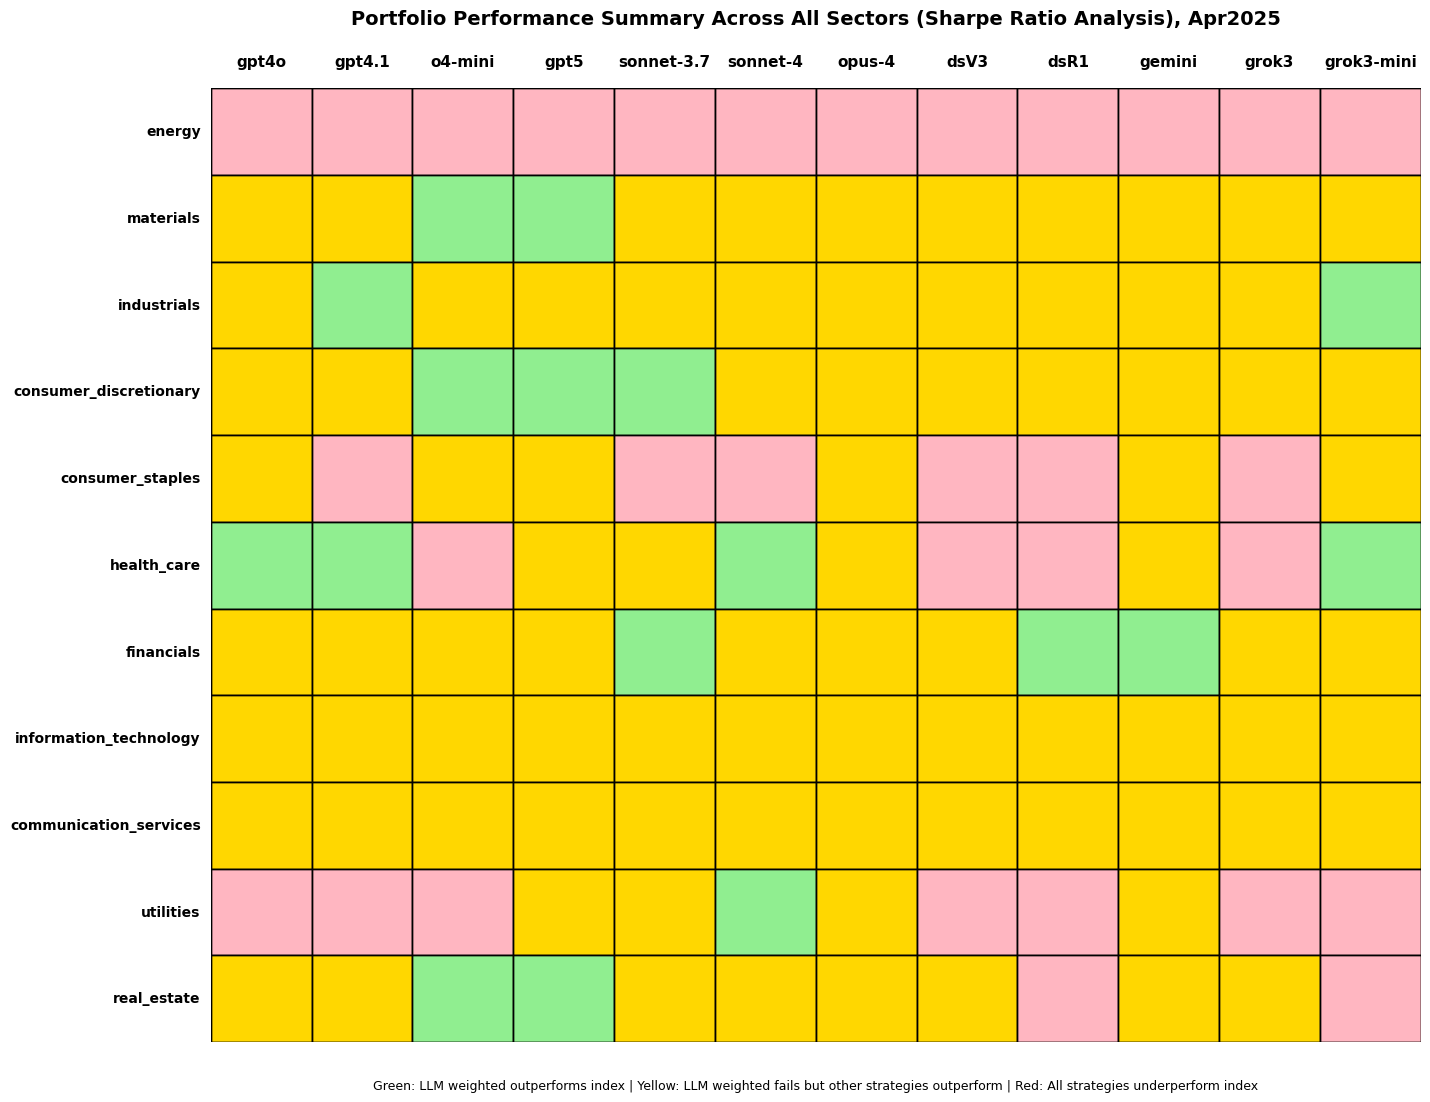

In [164]:
fig, ax = plt.subplots(figsize=(len(model_names)*1.2, len(summary_results.index)))

ax.set_xlim(0, len(model_names))
ax.set_ylim(0, len(summary_results.index))

# draw each cell
for i, sector in enumerate(summary_results.index):
    for j, model in enumerate(model_names):
        color = color_matrix.loc[sector, model]
        
        rect = patches.Rectangle((j, len(summary_results.index)-1-i), 1, 1, 
                               linewidth=1, edgecolor='black', facecolor=color)
        ax.add_patch(rect)
        
        # add sector labels
        if j == 0:
            ax.text(-0.1, len(summary_results.index)-1-i+0.5, sector, 
                   ha='right', va='center', fontweight='bold', fontsize=10)

# add model labels
for j, model in enumerate(model_names):
    ax.text(j+0.5, len(summary_results.index)+0.3, model, 
           ha='center', va='center', fontweight='bold', fontsize=11)

# add grid line
for i in range(len(summary_results.index) + 1):
    ax.axhline(y=i, xmin=0, xmax=1, color='black', linewidth=1)
for j in range(len(model_names) + 1):
    ax.axvline(x=j, ymin=0, ymax=1, color='black', linewidth=1)

ax.text(len(model_names)/2, len(summary_results.index)+0.8, 
        f'Portfolio Performance Summary Across All Sectors (Sharpe Ratio Analysis), {time_split}', 
        ha='center', va='center', fontweight='bold', fontsize=14)

legend_text = ('Green: LLM weighted outperforms index | '
               'Yellow: LLM weighted fails but other strategies outperform | '
               'Red: All strategies underperform index')
ax.text(len(model_names)/2, -0.5, legend_text, ha='center', va='center', fontsize=9)

ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

plt.tight_layout()
plt.show()

## Maximum Drawdown

Maximum drawdowm is a risk indicator that measures a portfolio's maximum drop from its historical peak.

Drawdown ($D_t$):
$$
D_t = \frac{V_t - P_t}{P_t}
$$

In [40]:
# time_split = 'Oct2024'
# time_split = 'Jan2025'
# time_split = 'Apr2025'
time_split = 'Jan2025_6months'

In [41]:
columns = ['sector']
for model in model_names:
    columns.extend([
        f'{model}_model_weighted',
        f'{model}_equally_weighted', 
        f'{model}_minvar',
        f'{model}_maxret',
        f'{model}_maxsharpe',
    ])
if not os.path.exists(f'metrics/max_drawdowns_all_{time_split}.csv'):
    pd.DataFrame(columns=columns).to_csv(f'metrics/max_drawdowns_all_{time_split}.csv', index=False)

In [ ]:
def calculate_max_drawdown(returns_df, weights):
    portfolio_returns = (returns_df * weights.T).sum(axis=1)
    cumulative_returns = (1 + portfolio_returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdowns = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdowns.min()
    
    return max_drawdown

for sector_name in sectors:
    with open(f'metrics/max_drawdowns_all_{time_split}.csv', 'a', encoding='utf-8') as f:
        f.write(f'{sector_name},')

    for model in model_names:
        if model == 'gpt4o':
            csv_filename = f'cached/gpt/4o_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'gpt4.1':
            csv_filename = f'cached/gpt/4.1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'o4-mini':
            csv_filename = f'cached/gpt/o4-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'gpt-5':
            csv_filename = f'cached/gpt/5_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        # claude
        elif model == 'sonnet-3.7':
            csv_filename = f'cached/claude/sonnet-3.7_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'sonnet-4':
            csv_filename = f'cached/claude/sonnet-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'opus-4':
            csv_filename = f'cached/claude/opus-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        # ds
        elif model == 'dsV3':
            csv_filename = f'cached/ds/dsV3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'dsR1':
            csv_filename = f'cached/ds/dsR1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        # gemini
        elif model == 'gemini':
            csv_filename = f'cached/gemini/gemini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        # grok
        elif model == 'grok3':
            csv_filename = f'cached/grok/grok3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
        elif model == 'grok3-mini':
            csv_filename = f'cached/grok/grok3-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'

        
        portfolio = pd.read_csv(csv_filename)
        stocks_in_portfolio = portfolio['Stock']
        weights = np.array(portfolio.sort_values(by='Stock')['Weight']).reshape(-1,1)
        n = len(stocks_in_portfolio)
        weights_equal = np.array([1/n for _ in range(n)]).reshape(n,1)

        csv_filename_returns = f'4_returns_outsample/SP500_{sector_name}_returns_since_{time_split}.csv'
        returns_df = pd.read_csv(csv_filename_returns)
        returns_df_portfolio = returns_df[stocks_in_portfolio].sort_index(axis=1)

        path_minvar = f'cached/efficient_portfolios/{model}_{sector_name}_{time_split}_minvar_bounded.csv'
        df_minvar = pd.read_csv(path_minvar, header=None).transpose()
        df_minvar.columns = ['Stock', 'Weight']
        df_minvar = df_minvar.sort_values(by='Stock')
        weights_minvar = np.array(df_minvar['Weight'].apply(lambda x: float(x)).tolist()).reshape(len(df_minvar),1)
        returns_df_minvar = returns_df[df_minvar['Stock']].sort_index(axis=1)

        path_maxret = f'cached/efficient_portfolios/{model}_{sector_name}_{time_split}_maxret_bounded.csv'
        df_maxret = pd.read_csv(path_maxret, header=None).transpose()
        df_maxret.columns = ['Stock', 'Weight']
        df_maxret = df_maxret.sort_values(by='Stock')
        weights_maxret = np.array(df_maxret['Weight'].apply(lambda x: float(x)).tolist()).reshape(len(df_maxret),1)
        returns_df_maxret = returns_df[df_maxret['Stock']].sort_index(axis=1)

        path_maxsharpe = f'cached/efficient_portfolios/{model}_{sector_name}_{time_split}_maxsharpe_bounded.csv'
        df_maxsharpe = pd.read_csv(path_maxsharpe, header=None).transpose()
        df_maxsharpe.columns = ['Stock', 'Weight']
        df_maxsharpe = df_maxsharpe.sort_values(by='Stock')
        weights_maxsharpe = np.array(df_maxsharpe['Weight'].apply(lambda x: float(x)).tolist()).reshape(len(df_maxsharpe),1)
        returns_df_maxsharpe = returns_df[df_maxsharpe['Stock']].sort_index(axis=1)

        max_drawdown_weighted = calculate_max_drawdown(returns_df_portfolio, weights)
        max_drawdown_equal = calculate_max_drawdown(returns_df_portfolio, weights_equal)
        max_drawdown_minvar = calculate_max_drawdown(returns_df_minvar, weights_minvar)
        max_drawdown_maxret = calculate_max_drawdown(returns_df_maxret, weights_maxret)
        max_drawdown_maxsharpe = calculate_max_drawdown(returns_df_maxsharpe, weights_maxsharpe)

        print(f"{sector_name} {model} {max_drawdown_weighted:.4f} llm weighted")
        print(f"{sector_name} {model} {max_drawdown_equal:.4f} equally weighted")
        print(f"{sector_name} {model} {max_drawdown_minvar:.4f} minvar")
        print(f"{sector_name} {model} {max_drawdown_maxret:.4f} maxret")
        print(f"{sector_name} {model} {max_drawdown_maxsharpe:.4f} max sharpe")

        with open(f'metrics/max_drawdowns_all_{time_split}.csv', 'a', encoding='utf-8') as f:
            f.write(f'{max_drawdown_weighted},{max_drawdown_equal},{max_drawdown_minvar},{max_drawdown_maxret},{max_drawdown_maxsharpe},')

    with open(f'metrics/max_drawdowns_all_{time_split}.csv', 'a', encoding='utf-8') as f:
        f.write('\n')

energy gpt4o -0.2112 llm weighted
energy gpt4o -0.2322 equally weighted
energy gpt4o -0.1926 minvar
energy gpt4o -0.2480 maxret
energy gpt4o -0.2092 max sharpe
energy gpt4.1 -0.2110 llm weighted
energy gpt4.1 -0.2247 equally weighted
energy gpt4.1 -0.1866 minvar
energy gpt4.1 -0.2285 maxret
energy gpt4.1 -0.1891 max sharpe
energy o4-mini -0.2172 llm weighted
energy o4-mini -0.2247 equally weighted
energy o4-mini -0.1866 minvar
energy o4-mini -0.2285 maxret
energy o4-mini -0.1891 max sharpe
energy sonnet-3.7 -0.2039 llm weighted
energy sonnet-3.7 -0.2291 equally weighted
energy sonnet-3.7 -0.1855 minvar
energy sonnet-3.7 -0.2274 maxret
energy sonnet-3.7 -0.2013 max sharpe
energy sonnet-4 -0.1978 llm weighted
energy sonnet-4 -0.2322 equally weighted
energy sonnet-4 -0.1926 minvar
energy sonnet-4 -0.2480 maxret
energy sonnet-4 -0.2092 max sharpe
energy opus-4 -0.2070 llm weighted
energy opus-4 -0.2322 equally weighted
energy opus-4 -0.1926 minvar
energy opus-4 -0.2480 maxret
energy opus-4

In [43]:
with open(f'metrics/max_drawdowns_all_{time_split}.csv', 'r', encoding='utf-8') as f:
    lines = [line.rstrip(',\n') + '\n' for line in f]

with open(f'metrics/max_drawdowns_all_{time_split}.csv', 'w', encoding='utf-8') as f:
    f.writelines(lines)


In [44]:
df_preview = pd.read_csv(f'metrics/max_drawdowns_all_{time_split}.csv')
df_preview

,sector,gpt4o_model_weighted,gpt4o_equally_weighted,gpt4o_minvar,gpt4o_maxret,gpt4o_maxsharpe,gpt4.1_model_weighted,gpt4.1_equally_weighted,gpt4.1_minvar,gpt4.1_maxret,...,grok3_model_weighted,grok3_equally_weighted,grok3_minvar,grok3_maxret,grok3_maxsharpe,grok3-mini_model_weighted,grok3-mini_equally_weighted,grok3-mini_minvar,grok3-mini_maxret,grok3-mini_maxsharpe
0,energy,-0.211166,-0.232226,-0.192593,-0.247960,-0.209230,-0.211026,-0.224660,-0.186603,-0.228483,...,-0.213720,-0.232226,-0.192593,-0.247960,-0.209230,-0.198149,-0.224660,-0.186603,-0.228483,-0.189064
1,materials,-0.202764,-0.195516,-0.169971,-0.206189,-0.188908,-0.182939,-0.186530,-0.163663,-0.206553,...,-0.200452,-0.203940,-0.175878,-0.211230,-0.193450,-0.219634,-0.212348,-0.181596,-0.215538,-0.199864
2,industrials,-0.182090,-0.187958,-0.172825,-0.214569,-0.215995,-0.160803,-0.158021,-0.114284,-0.183948,...,-0.183443,-0.183578,-0.167131,-0.212058,-0.212058,-0.169678,-0.182707,-0.157719,-0.211630,-0.196710
3,consumer_discretionary,-0.211806,-0.181654,-0.152864,-0.187700,-0.202180,-0.205727,-0.180574,-0.143169,-0.231936,...,-0.215586,-0.157032,-0.129466,-0.173045,-0.173852,-0.202768,-0.175807,-0.142046,-0.191528,-0.180861
4,consumer_staples,-0.091439,-0.096056,-0.090303,-0.087204,-0.093914,-0.088785,-0.092713,-0.078953,-0.085151,...,-0.085906,-0.096920,-0.089956,-0.101499,-0.096623,-0.082774,-0.091338,-0.086067,-0.087856,-0.092411
5,health_care,-0.157242,-0.147836,-0.157617,-0.144866,-0.157574,-0.142719,-0.118518,-0.140631,-0.116662,...,-0.146177,-0.128977,-0.150444,-0.115936,-0.130613,-0.135409,-0.131597,-0.148401,-0.129478,-0.125803
6,financials,-0.174476,-0.178910,-0.135579,-0.184005,-0.147983,-0.163328,-0.160582,-0.123569,-0.185880,...,-0.209624,-0.193763,-0.144568,-0.222967,-0.210901,-0.182378,-0.180101,-0.141847,-0.193719,-0.169271
7,information_technology,-0.256617,-0.259381,-0.250239,-0.292809,-0.300379,-0.267683,-0.264435,-0.253164,-0.299644,...,-0.254835,-0.256882,-0.240923,-0.270023,-0.272380,-0.266919,-0.254810,-0.236659,-0.283207,-0.269470
8,communication_services,-0.157128,-0.148720,-0.103131,-0.176811,-0.162938,-0.154531,-0.147637,-0.103050,-0.176267,...,-0.163653,-0.147637,-0.103050,-0.176267,-0.162401,-0.167883,-0.145965,-0.102892,-0.174585,-0.160689
9,utilities,-0.079130,-0.076426,-0.075749,-0.068360,-0.069460,-0.077404,-0.073543,-0.074600,-0.066489,...,-0.078052,-0.076263,-0.075960,-0.068322,-0.069398,-0.074592,-0.074575,-0.076532,-0.068095,-0.071643


## Maximum Drawdown: sector indices

In [45]:
# time_split = 'Oct2024'
# time_split = 'Jan2025'
# time_split = 'Apr2025'
time_split = 'Jan2025_6months'

In [47]:
if time_split == 'Oct2024': 
    ## In-sample end date (using 5 years of weekly data prior to end date)
    insample_enddate = datetime(2024, 9, 30)

    ## Out-of-sample period (1 Oct 2024 to 31 Dec 2024) (using daily data))
    outsample_startdate = datetime(2024, 10, 1)
    outsample_enddate   = datetime(2024, 12, 31)

    insample_startdate = insample_enddate - timedelta(weeks=5*52) # five years prior to October 2024
elif time_split == 'Jan2025':
    ## In-sample end date (using 5 years of weekly data prior to end date)
    insample_enddate = datetime(2024, 12, 31)

    ## Out-of-sample period (1 Jan 2025 to 31 Mar 2025) (using daily data))
    outsample_startdate = datetime(2025, 1, 1)
    outsample_enddate   = datetime(2025, 3, 31)

    insample_startdate = insample_enddate - timedelta(weeks=5*52)
elif time_split == 'Apr2025':
    ## In-sample end date (using 5 years of weekly data prior to end date)
    insample_enddate = datetime(2025, 3, 31)

    ## Out-of-sample period (1 Apr 2025 to 30 Jun 2025) (using daily data))
    outsample_startdate = datetime(2025, 4, 1)
    outsample_enddate   = datetime(2025, 6, 30)

    insample_startdate = insample_enddate - timedelta(weeks=5*52)
elif time_split == 'Jan2025_6months':
    ## In-sample end date (using 5 years of weekly data prior to end date)
    insample_enddate = datetime(2024, 12, 31)

    ## Out-of-sample period (1 Jan 2025 to 30 Jun 2025) (using daily data))
    outsample_startdate = datetime(2025, 1, 1)
    outsample_enddate   = datetime(2025, 6, 30)

    insample_startdate = insample_enddate - timedelta(weeks=5*52)

In [48]:
index_tickers = ["^GSPE", '^SP500-15', '^SP500-20', '^SP500-25', '^SP500-30', '^SP500-35', '^SP500-40',\
                 '^SP500-45', '^SP500-50', '^SP500-55', '^SP500-60']

index_data_outs = pd.DataFrame()

for ticker in index_tickers:
    yf_outsample_enddate = outsample_enddate + timedelta(days=1)  # Adjust to include the end date
    index_df = yf.download(ticker, start=outsample_startdate, end=yf_outsample_enddate, interval='1d', auto_adjust=False)
    index_df['Index_Return'] = index_df['Adj Close'].pct_change()
    index_df.dropna(subset=[('Index_Return','')], inplace=True)
    index_data_outs[ticker] = index_df['Index_Return']

index_data_outs.index = pd.to_datetime(index_data_outs.index)

valid_index_tickers_outs = []

for ticker in index_tickers:
    if ticker in index_data_outs.columns and index_data_outs[ticker].notna().all():
        valid_index_tickers_outs.append(ticker)


index_tickers = valid_index_tickers_outs

print("Valid Index Tickers in Out-of-Sample Period")
print(valid_index_tickers_outs)
index_data_outs

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Valid Index Tickers in Out-of-Sample Period
['^GSPE', '^SP500-15', '^SP500-20', '^SP500-25', '^SP500-30', '^SP500-35', '^SP500-40', '^SP500-45', '^SP500-50', '^SP500-55', '^SP500-60']


,^GSPE,^SP500-15,^SP500-20,^SP500-25,^SP500-30,^SP500-35,^SP500-40,^SP500-45,^SP500-50,^SP500-55,^SP500-60
Date,,,,,,,,,,,
2025-01-03,0.008977,0.000286,0.011102,0.024243,0.000976,0.009869,0.007898,0.016241,0.007939,0.010986,0.013428
2025-01-06,-0.004074,0.006547,-0.002118,0.006108,-0.009802,-0.000185,-0.004177,0.014386,0.021323,-0.010943,-0.014897
2025-01-07,0.010649,-0.000152,-0.001017,-0.022108,-0.002718,0.005831,-0.001539,-0.023920,-0.010538,-0.002914,-0.006208
2025-01-08,-0.000982,0.004893,0.004115,0.002426,0.004582,0.005319,0.003033,0.000951,-0.007395,-0.000103,0.003964
2025-01-10,0.003426,-0.009796,-0.011058,-0.009735,-0.011291,-0.005755,-0.024500,-0.022275,-0.010010,-0.005717,-0.023811
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-24,-0.015136,0.007513,0.008564,0.007132,-0.000344,0.011940,0.014954,0.016114,0.013896,0.003949,0.003855
2025-06-25,-0.004343,-0.007927,-0.009272,-0.011255,-0.013896,0.000891,-0.003844,0.011807,0.005074,-0.013682,-0.025361
2025-06-26,0.015033,0.010884,0.011044,0.011802,-0.001799,0.002369,0.007553,0.006783,0.017725,0.008196,-0.007802


In [49]:
max_drawdown = {}
for column in index_data_outs.columns:
    returns = index_data_outs[column]
    cumulative_returns = (1 + returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdowns = (cumulative_returns - running_max) / running_max
    max_drawdown[column] = drawdowns.min()

max_drawdown_df = pd.DataFrame.from_dict(max_drawdown, orient='index', columns=['Max Drawdown'])
max_drawdown_df.index.name = 'Index'

print(max_drawdown_df)

           Max Drawdown
Index                  
^GSPE         -0.184261
^SP500-15     -0.179900
^SP500-20     -0.178174
^SP500-25     -0.264014
^SP500-30     -0.093797
^SP500-35     -0.138627
^SP500-40     -0.157013
^SP500-45     -0.263121
^SP500-50     -0.228092
^SP500-55     -0.087549
^SP500-60     -0.149252


In [50]:
df = pd.read_csv(f'metrics/max_drawdowns_all_{time_split}.csv')
df

,sector,gpt4o_model_weighted,gpt4o_equally_weighted,gpt4o_minvar,gpt4o_maxret,gpt4o_maxsharpe,gpt4.1_model_weighted,gpt4.1_equally_weighted,gpt4.1_minvar,gpt4.1_maxret,...,grok3_model_weighted,grok3_equally_weighted,grok3_minvar,grok3_maxret,grok3_maxsharpe,grok3-mini_model_weighted,grok3-mini_equally_weighted,grok3-mini_minvar,grok3-mini_maxret,grok3-mini_maxsharpe
0,energy,-0.211166,-0.232226,-0.192593,-0.247960,-0.209230,-0.211026,-0.224660,-0.186603,-0.228483,...,-0.213720,-0.232226,-0.192593,-0.247960,-0.209230,-0.198149,-0.224660,-0.186603,-0.228483,-0.189064
1,materials,-0.202764,-0.195516,-0.169971,-0.206189,-0.188908,-0.182939,-0.186530,-0.163663,-0.206553,...,-0.200452,-0.203940,-0.175878,-0.211230,-0.193450,-0.219634,-0.212348,-0.181596,-0.215538,-0.199864
2,industrials,-0.182090,-0.187958,-0.172825,-0.214569,-0.215995,-0.160803,-0.158021,-0.114284,-0.183948,...,-0.183443,-0.183578,-0.167131,-0.212058,-0.212058,-0.169678,-0.182707,-0.157719,-0.211630,-0.196710
3,consumer_discretionary,-0.211806,-0.181654,-0.152864,-0.187700,-0.202180,-0.205727,-0.180574,-0.143169,-0.231936,...,-0.215586,-0.157032,-0.129466,-0.173045,-0.173852,-0.202768,-0.175807,-0.142046,-0.191528,-0.180861
4,consumer_staples,-0.091439,-0.096056,-0.090303,-0.087204,-0.093914,-0.088785,-0.092713,-0.078953,-0.085151,...,-0.085906,-0.096920,-0.089956,-0.101499,-0.096623,-0.082774,-0.091338,-0.086067,-0.087856,-0.092411
5,health_care,-0.157242,-0.147836,-0.157617,-0.144866,-0.157574,-0.142719,-0.118518,-0.140631,-0.116662,...,-0.146177,-0.128977,-0.150444,-0.115936,-0.130613,-0.135409,-0.131597,-0.148401,-0.129478,-0.125803
6,financials,-0.174476,-0.178910,-0.135579,-0.184005,-0.147983,-0.163328,-0.160582,-0.123569,-0.185880,...,-0.209624,-0.193763,-0.144568,-0.222967,-0.210901,-0.182378,-0.180101,-0.141847,-0.193719,-0.169271
7,information_technology,-0.256617,-0.259381,-0.250239,-0.292809,-0.300379,-0.267683,-0.264435,-0.253164,-0.299644,...,-0.254835,-0.256882,-0.240923,-0.270023,-0.272380,-0.266919,-0.254810,-0.236659,-0.283207,-0.269470
8,communication_services,-0.157128,-0.148720,-0.103131,-0.176811,-0.162938,-0.154531,-0.147637,-0.103050,-0.176267,...,-0.163653,-0.147637,-0.103050,-0.176267,-0.162401,-0.167883,-0.145965,-0.102892,-0.174585,-0.160689
9,utilities,-0.079130,-0.076426,-0.075749,-0.068360,-0.069460,-0.077404,-0.073543,-0.074600,-0.066489,...,-0.078052,-0.076263,-0.075960,-0.068322,-0.069398,-0.074592,-0.074575,-0.076532,-0.068095,-0.071643


In [51]:
sector_max_drawdown = dict(max_drawdown_df['Max Drawdown'])
sector_max_drawdown = {index_to_sector[k]: v for k, v in sector_max_drawdown.items()}
sector_max_drawdown

{'energy': -0.18426128560256955,
 'materials': -0.17990004791857994,
 'industrials': -0.17817413663056147,
 'consumer_discretionary': -0.2640144423122121,
 'consumer_staples': -0.0937969885199784,
 'health_care': -0.13862719839928286,
 'financials': -0.15701337281361294,
 'information_technology': -0.2631214464813847,
 'communication_services': -0.22809241732589705,
 'utilities': -0.08754946255483362,
 'real_estate': -0.14925211024061402}

In [ ]:
model_names = ["gpt4o", "gpt4.1", "o4-mini", "gpt-5", "sonnet-3.7", "sonnet-4", "opus-4", "dsV3", "dsR1", "gemini", "grok3", "grok3-mini"]
summary_results = pd.DataFrame(index=sectors, columns=model_names)

for sector in sectors:
    sector_benchmark = sector_max_drawdown[sector]
    sector_data = df[df['sector'] == sector].iloc[0]
    for model in model_names:
        model_weighted = sector_data[f'{model}_model_weighted']
        equally_weighted = sector_data[f'{model}_equally_weighted']
        minvar = sector_data[f'{model}_minvar']
        maxret = sector_data[f'{model}_maxret']
        maxsharpe = sector_data[f'{model}_maxsharpe']

        model_weighted_outperformed = model_weighted > sector_benchmark
        other_strategies = [equally_weighted, minvar, maxret, maxsharpe]
        any_other_outperformed = any(strategy > sector_benchmark for strategy in other_strategies)

        if model_weighted_outperformed:
            color = 'green'
            summary_results.loc[sector, model] = 2  
        elif any_other_outperformed:
            color = 'yellow'
            summary_results.loc[sector, model] = 1  
        else:
            color = 'red'
            summary_results.loc[sector, model] = 0  
summary_results

,gpt4o,gpt4.1,o4-mini,sonnet-3.7,sonnet-4,opus-4,dsV3,dsR1,gemini,grok3,grok3-mini
energy,0,0,0,0,0,0,0,0,0,0,0
materials,1,1,1,1,0,1,0,1,1,1,0
industrials,1,2,1,1,1,2,1,1,2,1,2
consumer_discretionary,2,2,2,2,2,2,2,2,2,2,2
consumer_staples,2,2,1,2,2,1,2,2,2,2,2
health_care,0,1,1,2,1,2,0,1,2,1,2
financials,1,1,1,2,1,1,1,1,2,1,1
information_technology,2,1,2,1,2,2,2,1,1,2,1
communication_services,2,2,2,2,2,2,2,2,2,2,2
utilities,2,2,2,2,1,1,2,2,2,2,2


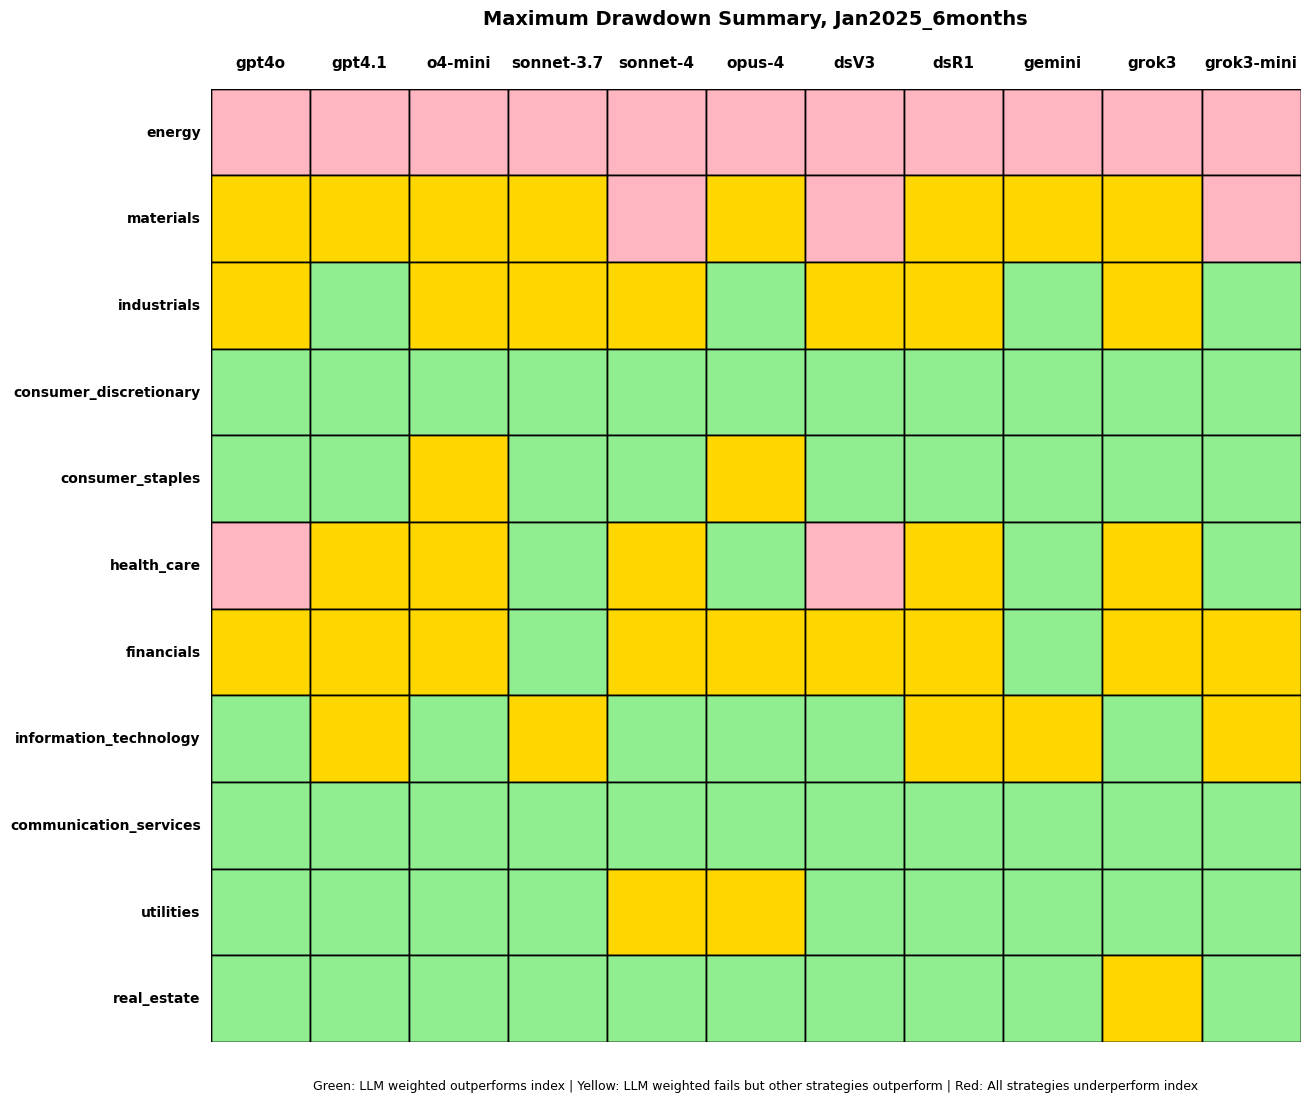

In [ ]:
color_map = {0: '#FFB6C1', 1: '#FFD700', 2: '#90EE90'}
color_matrix = summary_results.copy()
for sector in summary_results.index:
    for model in summary_results.columns:
        color_matrix.loc[sector, model] = color_map[summary_results.loc[sector, model]]
fig, ax = plt.subplots(figsize=(len(model_names)*1.2, len(summary_results.index)))

ax.set_xlim(0, len(model_names))
ax.set_ylim(0, len(summary_results.index))

for i, sector in enumerate(summary_results.index):
    for j, model in enumerate(model_names):
        color = color_matrix.loc[sector, model]
        
        rect = patches.Rectangle((j, len(summary_results.index)-1-i), 1, 1, 
                               linewidth=1, edgecolor='black', facecolor=color)
        ax.add_patch(rect)
  
        if j == 0:
            ax.text(-0.1, len(summary_results.index)-1-i+0.5, sector, 
                   ha='right', va='center', fontweight='bold', fontsize=10)

for j, model in enumerate(model_names):
    ax.text(j+0.5, len(summary_results.index)+0.3, model, 
           ha='center', va='center', fontweight='bold', fontsize=11)

for i in range(len(summary_results.index) + 1):
    ax.axhline(y=i, xmin=0, xmax=1, color='black', linewidth=1)
for j in range(len(model_names) + 1):
    ax.axvline(x=j, ymin=0, ymax=1, color='black', linewidth=1)

ax.text(len(model_names)/2, len(summary_results.index)+0.8, 
        f'Maximum Drawdown Summary, {time_split}', 
        ha='center', va='center', fontweight='bold', fontsize=14)

legend_text = ('Green: LLM weighted outperforms index | '
               'Yellow: LLM weighted fails but other strategies outperform | '
               'Red: All strategies underperform index')
ax.text(len(model_names)/2, -0.5, legend_text, ha='center', va='center', fontsize=9)

ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

plt.tight_layout()
plt.show()